In [1]:
import astropy.units as u
# from astropy.coordinates.sky_coordinate import SkyCoord
# from astropy.units import Quantity
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
import numpy as np
import time
# from astroquery.simbad import Simbad
# import astropy 
# from astropy.table import Table
from astropy.io.votable import parse
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
import corner
%matplotlib inline

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
from joblib import Memory
cachedir = "./joblib_cache"
memory = Memory(cachedir, verbose=0, bytes_limit=1e7)

In [3]:
@memory.cache
def get_gaia_query(q):
    """checks request against previous querys and returns a table containing the results of the query
    
    returns: astropy table"""
    start = time.time()
    job = Gaia.launch_job_async(q)
    print(f"Total time: {time.time() - start:0.2f} sec")
    return job.get_results()

# 1.1 

In [4]:
rr_lyrae_query = "SELECT top 100 * \
FROM gaiadr2.vari_rrlyrae \
WHERE pf !=0 \
AND num_clean_epochs_g>40;"

rr_lyrae_sample = get_gaia_query(rr_lyrae_query)
len(rr_lyrae_sample)

100

In [5]:
rr_lyrae_sample[:10]

solution_id,source_id,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification
,,d,d,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,dex,dex,,,,,rad,rad,rad,rad,,,,mag,mag,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,object
369295551293819386,5866125710834119808,0.45207240076998667,1.3003196171988113e-06,--,--,--,--,--,--,1700.6320136814795,1.8389296380623503e-06,1783.0270727437294,1.8389296380623503e-06,1783.019968286169,1.8389296380623503e-06,19.829002378100697,0.0017611118938539022,20.05887749491192,0.055322172004415006,18.142943674742085,0.00980144855856893,0.6108646433568055,0.010067274726763064,0.5065093441972692,0.2519379630043119,0.03224426272644365,0.060876173636291726,--,--,0.5597453419602187,0.01980461486583596,--,--,3.4572796602163507,0.04746986161849459,--,--,57,17,16,6.536679457310559,0.0873667746655819,RRab
369295551293819386,5978435871487788288,0.648442595496394,1.3470624322336533e-06,--,--,--,--,--,--,1709.290949398965,1.9050339610281209e-06,1709.3140540338713,1.9050339610281209e-06,1709.3121406809541,1.9050339610281209e-06,18.37905582817158,0.0006249688617317147,19.477055011641482,0.015789720173731918,17.15073891619941,0.007089873749929578,0.48610466902325555,0.0033637645178221307,0.5504655470455546,0.07245157079537685,0.25297190255184177,0.02761626747777527,-0.04347318266439615,0.21938697428693577,0.46211654418447684,0.008444382809350011,0.2652076445305246,0.007413715850295902,4.565746788759661,0.02263850113372803,3.151089820159477,0.033069106819820455,41,35,32,3.6473370781995142,0.06448844234447489,RRab
369295551293819386,5704736782734774528,0.6270046382069818,2.9805914933406168e-06,--,--,--,--,--,--,1762.1223170527178,4.215192913776177e-06,1762.1189367162933,4.215192913776177e-06,1762.3000815733121,4.215192913776177e-06,18.367183031320444,0.000554359615774292,18.508340417630986,0.004206101573781567,18.009453610798094,0.005351562385562215,0.3653407502087944,0.0020185600813135713,0.37852292089716855,0.019769325593019194,0.17414816631826113,0.02849018063584878,--,--,--,--,--,--,--,--,--,--,44,37,34,--,--,RRab
369295551293819386,5816755332315333888,0.7913965498561393,1.5092189854296103e-06,--,--,--,--,--,--,1703.9974761976036,2.1343579577855177e-06,1704.0167528948207,2.1343579577855177e-06,1704.0430912518177,2.1343579577855177e-06,17.585120849505195,0.0003669927387024788,17.894023067042163,0.0019130044814337321,17.083056145932968,0.002077515536999311,0.4801964780016412,0.0017617249265559454,0.5403224127139836,0.013485703925518205,0.3496465663698096,0.010182531120406948,-0.38174293640950197,0.21916524180764185,0.4221742759106887,0.0034878987822288443,0.21975978846114191,0.003453219779328249,4.460737439139983,0.01148835315771656,3.0009840648164285,0.016616872447630462,68,65,61,0.334260602939929,0.051369448434517836,RRab
369295551293819386,5821611776409134976,0.7982343357378148,1.349458892612425e-06,--,--,--,--,--,--,1702.5290893966207,1.90842306779747e-06,1702.514925327494,1.90842306779747e-06,1702.5339602708698,1.90842306779747e-06,16.457312500364054,0.00019430738023192256,16.73802747970098,0.0012066558508083242,15.995031964185294,0.0014031686149913482,0.44558736648837893,0.0012549092356595821,0.55281

# 1.2 

In [6]:
joined_query = "SELECT TOP 100 * \
FROM gaiadr2.gaia_source \
JOIN gaiadr2.vari_rrlyrae using (source_id) \
WHERE pf !=0 \
AND num_clean_epochs_g>40;"

joined_sample = get_gaia_query(joined_query)
len(joined_sample)

100

In [7]:
@memory.cache
def light_curve_from_url(url, quality_cuts=False):
    """Takes a url from the joined gaiadr2.gaia_source and gaiadr2.vari_rrlyrae
    table column 'epoch_photometry_url' and returns the rows corresponding
    to G-band measurements that did not fail photometry or variability
    
    Parameter: url from 'epoch_photometry_url' column
    
    Returns: astropy Table of the light curve data"""
    lightcurve_url = str(url)[2:-1]
    votable = parse(f"{lightcurve_url}")
    tbl = votable.get_first_table().to_table()
    G_band = np.where(tbl["band"]==b'G')
    tbl = tbl[G_band]
    if quality_cuts:
        passes_photometry = tbl["rejected_by_photometry"] == False
        tbl = tbl[passes_photometry]
        passes_variability = tbl["rejected_by_variability"] == False
        return tbl[passes_variability]
    return tbl

In [8]:
all_light_curves = []

for i, row in enumerate(joined_sample):
    url = row["epoch_photometry_url"]
    tbl = light_curve_from_url(url)
    all_light_curves.append(tbl)

In [9]:
all_light_curves[0]

source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
,,,d,mag,e-/s,e-/s,,,,,
int64,int64,object,float64,float64,float64,float64,float32,bool,bool,int64,int64
5866125710834119808,16871156997575855,G,1701.9493526573233,19.477046430647494,305.16007839226535,10.351193788601622,29.480665,False,False,4103,369295551293819386
5866125710834119808,16875249299403399,G,1702.0233547653645,19.49079150179758,301.3212006964909,5.423949722368255,55.553833,False,False,1,369295551293819386
5866125710834119808,18799460942635593,G,1736.8193800408312,20.00661277813589,187.3704840727822,14.374171895815195,13.035219,False,False,8355841,369295551293819386
5866125710834119808,21385141519295611,G,1783.5789072302643,19.881291575594986,210.2953451732907,14.664466703812831,14.34047,False,False,8355841,369295551293819386
5866125710834119808,21408715614860113,G,1784.0052337615518,20.063026865932933,177.88344991622716,14.072553462412328,12.640453,False,False,8355841,369295551293819386
5866125710834119808,21412807905957436,G,1784.0792409638411,20.009383717853375,186.89289996524707,16.738739237720832,11.165292,False,False,8355841,369295551293819386
5866125710834119808,21422548704445311,G,1784.2555956822282,19.934539743600627,200.230574117571,5.359752450535676,37.358177,False,False,4194817,369295551293819386
5866125710834119808,21426640976013111,G,1784.329630688782,19.909160217560547,204.96617805345616,7.923650649154489,25.867645,False,False,1,369295551293819386


In [10]:
light_curve = all_light_curves[6]
sid = light_curve["source_id"][0]

[Error on magnitude](http://slittlefair.staff.shef.ac.uk/teaching/phy217/lectures/stats/L18/index.html) source to calculate uncertainty in the magnitude.

$\sigma_m \approx 1.09\dfrac{\sigma_f}{f}$ , where $\sigma_i$ is the uncertainty in the measurement

In [11]:
sigma_m = 1.09*(1/light_curve["flux_over_error"])

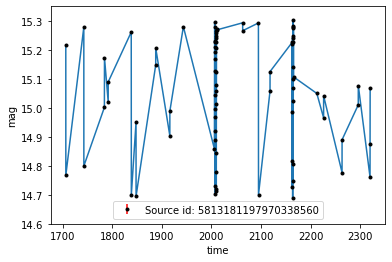

In [12]:
plt.figure()
plt.plot(light_curve["time"], light_curve["mag"])
plt.errorbar(light_curve["time"], light_curve["mag"], ecolor="red", yerr=sigma_m, fmt='.k', label="Source id: %s"%sid)
plt.xlabel("time")
plt.ylabel("mag")
plt.legend(loc="lower center")
plt.ylim(14.6, 15.35)
plt.show()

# 1.3 

This function finds the index of the max value of the power. This should correspond with the frequency of the variable star (assuming reasonably chosen initial frequency boundaries). It excludes values of infinity and NaN in the array because they do not make sense physically and will throw off the result of the calculation. 

[source](https://www.aanda.org/articles/aa/full_html/2018/08/aa32756-18/aa32756-18.html?fbclid=IwAR0bGz7kqONgB-5_vQyHkZyxzO8PRPe6GWIA0RArjjsArTHX66NHxzjEru0#T2)

In [13]:
def get_max_index(arr):
    """returns the index of the max value of an array
    checks array for NANs and replaces any present with zero"""
    arr[np.isnan(arr)] = 0
    arr[np.isinf(arr)] = 0
    return np.argmax(arr)

In [14]:
t = light_curve["time"]/u.day
y = light_curve["mag"]/u.mag
err = np.asarray(sigma_m)
frequency, power = LombScargle(t, y).autopower(minimum_frequency=0.25, 
                                               maximum_frequency=5,
                                               normalization='psd',
                                               samples_per_peak=5*2,
                                               nyquist_factor=5)

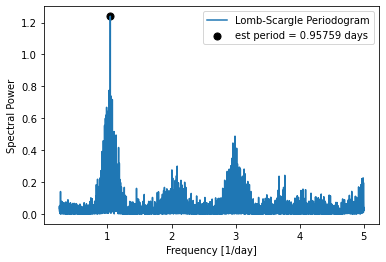

In [15]:
plt.figure()
max_power_index = get_max_index(power)
plt.plot(frequency, power, label="Lomb-Scargle Periodogram")
plt.scatter(frequency[max_power_index], power[max_power_index], color="black",
            s=50, label="est period = %s "%np.round(1/frequency[max_power_index], decimals=5)+"days")
plt.ylabel("Spectral Power")
plt.xlabel("Frequency [1/day]")
plt.legend(loc="upper right")

In [16]:
est_period = 1/frequency[max_power_index]
print("The estimated period from this light curve is %s days"%est_period)

The estimated period from this light curve is 0.9575883238813511 days


To determine the average magnitude of the source, we will first calculate the mean flux and then convert the mean flux back into a magnitude. 

In [17]:
mean_mag = np.log10(np.mean(10**light_curve["mag"]))
print("The mean magnitude of this light curve is %s"%np.round(mean_mag, decimals=5))

The mean magnitude of this light curve is 15.09186


In [18]:
def get_period(light_curve):
    """estimates the period of the variable star
    by finding the frequency with the highest power using a 
    Lomb-Scargle periodogram"""
    t = light_curve["time"]/u.day
    y = light_curve["mag"]/u.mag
    frequency, power = LombScargle(t, y).autopower(minimum_frequency=0.25, 
                                                   maximum_frequency=5,
                                                   normalization='psd',
                                                   samples_per_peak=5*2,
                                                   nyquist_factor=5)
    
    max_power_index = get_max_index(power)
    return 1/frequency[max_power_index]

In [19]:
import warnings
warnings.filterwarnings('ignore')

# 1.4 

In [20]:
periods = []

for lc in all_light_curves:
    period = get_period(lc)
    periods.append(period)

In [21]:
def compare_period_to_gaia(row, light_curve, verbose=False):
    """estimates the period based on the light curve data and 
    calculates the residual between it and 
    the value listed in the gaia catalog"""
    gaia_period = row["pf"]
    #light_curve = light_curve_from_url(row["epoch_photometry_url"])
    estimated_period = get_period(light_curve)
    residual = (gaia_period - estimated_period)
    return residual

In [22]:
compare_period_to_gaia(joined_sample[6], all_light_curves[6])

<Quantity 6.23284029e-05>

In [23]:
residuals = []

for i, row in enumerate(joined_sample):
    one_residual = compare_period_to_gaia(row, all_light_curves[i])
    residuals.append(one_residual)

### These comparisons were with the frequency

My results using the Lomb-Scargle periodogram gave me percent differences within 0.01% for 97 of the 100 sources. The remaining three had percent errors of 1.2%, 25.5%, and 863%. These sources require further analysis to determine what the cause of such a large error is.

I will try increasing the minimum frequency from 0 to 0.25 (needs justification) and see how that changes my results. This fixed the problem of having >800% error, but the 25% and 1.2% error results still remain.

Changing the `samples_per_peak` parameter from 5 to 10 fixed the issue of having a 1.2% error, but the 25% error is still persisting. 

In [24]:
arr = np.asarray(residuals)

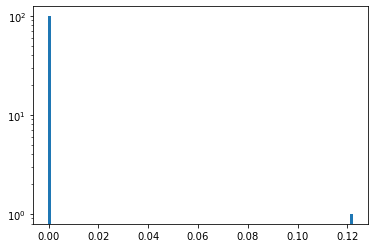

In [25]:
plt.figure()
_ = plt.hist(arr, bins=100)
plt.yscale("log")

In [26]:
np.argmax(np.abs(np.asarray(residuals)))

58

# 1.5

\begin{equation}
    \begin{bmatrix}
    f(t_0) \\
    f(t_1) \\
    \vdots \\
    f(t_{2k+1}) \\
    \end{bmatrix}
    =
    \begin{bmatrix}
    1 & sin(\omega t_0) & ... & sin(k \omega t_0) & cos(\omega t_0) & ... & cos(k \omega t_0) \\
    1 & sin(\omega t_1) & ... & sin(k \omega t_1) & cos(\omega t_1) & ... & cos(k \omega t_1) \\
    \vdots &  & ... & \vdots & \vdots & ... & \vdots \\
    1 & sin(\omega t_{2k+1}) & ... & sin(k \omega t_{2k+1}) & cos(\omega t_{2k+1}) & ... & cos(k \omega t_{2k+1}) \\
    \end{bmatrix}
    \begin{bmatrix}
    A_0 \\
    a_1 \\
    \vdots \\
    a_k \\
    b_1 \\
    \vdots \\
    b_k \\
    \end{bmatrix}
\end{equation}


# 1.6

The fourier fit function below was greatly informed by this [stack overflow post](https://stackoverflow.com/questions/32590720/create-scipy-curve-fitting-definitions-for-fourier-series-dynamically)

In [27]:
def fourier_fit(x, y, P, degree):
    """calculated the best fourier fit of a set of data given 
    some initial parameters:
    
    x: an array of the horizontal values of the data we want to fit
    
    y: an array of the vertical values of the data we want to fit 
    
    P: the estimated period of the data 
    
    degree: the number of harmonics we want to include 
            in our fourier series fit
            
    returns: x; the values of the horizontal data passed in initially
             y; the vertical points generated by the best fit fourier parameters
             popt; the fourier coefficients that construct the fit"""
    w = 2*np.pi/P
    degree = degree
    
    def fourier_sum(x, *a):
        """a helper class that computes a fourier series 
        composed of both sine and cosine terms"""
        #put together the sin terms first with degree+1 terms
        ret = a[0]
        for deg in range(1, degree+1):
            ret += a[deg]*np.sin((deg)*w*x)
            ret += a[deg+degree]*np.cos((deg)*w*x)
        return ret
    
    popt, pcov = curve_fit(fourier_sum, x, y, [1.0]*(2*degree + 1))
    
    return x, fourier_sum(x, *popt), popt

In [28]:
rr_lyrae_sample[6]["source_id"]

5813181197970338560

In [29]:
def strip_units_but_better(time, brightness, est_period):
    """takes in arrays of time, flux and the estimated period
    and returns a pandas dataframe with unitless entries, sorted by phase"""
    phase = np.asarray(time)%float(est_period)
    brightness = np.asarray(brightness)
    est_period = float(est_period)
    
    df = pd.DataFrame()
    df.insert(0, "mag", brightness)
    df.insert(0, "phase", phase)
    df = df.sort_values("phase")
    
    return np.asarray(df["phase"]), np.asarray(df["mag"]), est_period

In [30]:
phase, mag, per = strip_units_but_better(light_curve["time"], light_curve["mag"], est_period)

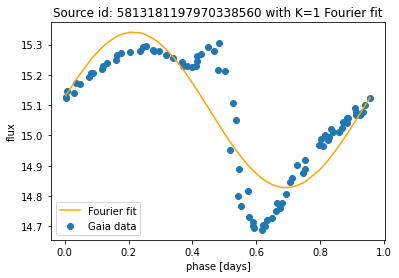

In [31]:
x, y, a = fourier_fit(phase, mag, per, 1)
plt.figure()
plt.scatter(phase, mag, label="Gaia data")
plt.plot(x, y, color="orange", label="Fourier fit")
plt.xlabel("phase [days]")
plt.ylabel("flux")
plt.title("Source id: %s with K=1 Fourier fit"%sid)
plt.legend(loc="lower left")
plt.show()

In [32]:
def fourier_residuals(data_x, data_y, P, K):
    """calculates the fourier series of order K fit to
    the given data and calculates the residuals"""
    fit_x, fit_y, a = fourier_fit(data_x, data_y, P, K)
    diff_y = fit_y-data_y
    return diff_y

In [33]:
def plot_fourier_fit(x, y, P, K, residuals=False, saving=False):
    """"""
    fit_x, fit_y, a = fourier_fit(x, y, P, K)
    
    if residuals:
        residual_y = y-fit_y
        fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios":[2,1]}, figsize=(6,6))
        plt.subplots_adjust(hspace=0.1)
        
        ax1.plot(fit_x, fit_y, color="Orange", label="K=%s Fourier fit"%K)
        ax1.scatter(x, y, label="GDR2 Data")
        ax1.set_ylabel("Magnitude")
        ax1.legend()
        
        
        ax2.scatter(x, residual_y, color="red", label="residuals")
        ax2.plot(x, np.zeros(len(x)), color="black")
        ax2.set_ylim(-0.3, 0.35)
        ax2.set_xlabel("Phase [days]")
        ax2.legend()
        if saving:
            plt.savefig("Residuals_K_%s.pdf"%K)
    else:
        plt.figure()
        plt.scatter(x, y, label="GDR2 Data")
        plt.plot(fit_x, fit_y, color="Orange", label="K=%s Fourier fit"%K)
        plt.legend()
        plt.xlabel("Phase")
        plt.ylabel("Magnitude")
        if saving:
            plt.savefig("Fourier_fit_K_%s.pdf"%K)
        plt.show()

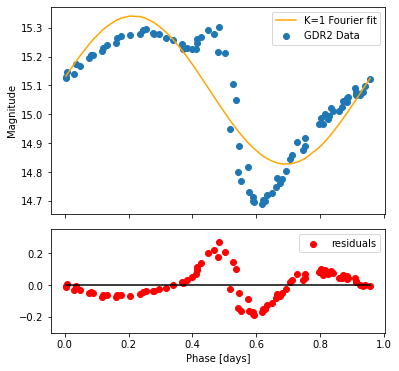

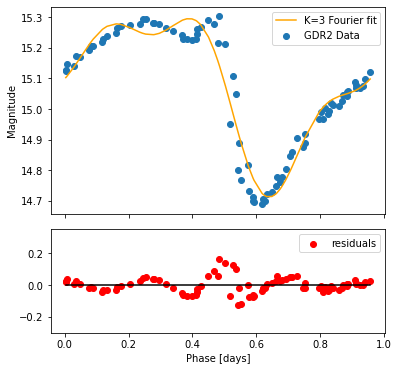

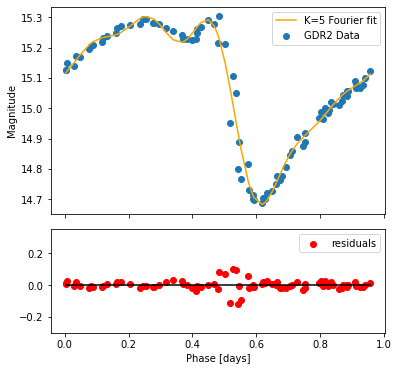

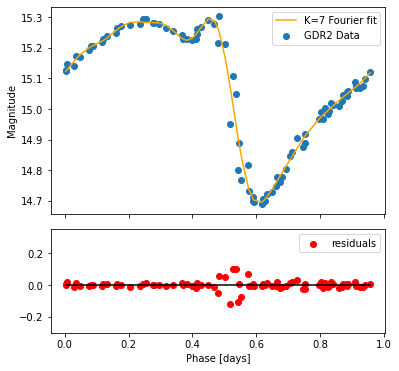

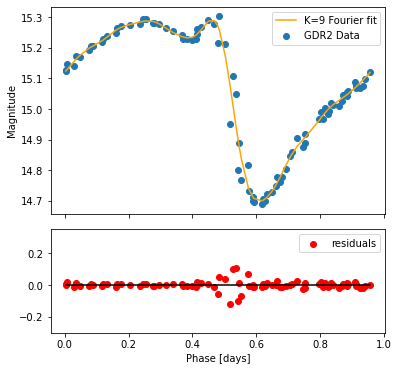

In [34]:
x = phase
y = mag
P = per
k_values = [1,3,5,7,9]

for value in k_values:
    plot_fourier_fit(x, y, P, value, residuals=True, saving=True)

Based on the residuals from the plots above, we can see that the fit gets better as the number of fourier terms increases. Due to the discrete nature of the dataset, we cannot use an infinite number of fourier terms to get the best possible fit; doing so will result in overfitting and will diminish the accuracy of the prediction. To determine the ideal number of fourier terms, we will employ cross validation to test how good our fit is for a various number of fourier terms. This will be done by breaking up our dataset into a "training" set and a "testing" set, where we will use the training set to fit a model to and test it on the testing data. This technique allows us to see how well the model performs on data it has not "seen" yet.

# 1.7

In [35]:
from sklearn.linear_model import LogisticRegressionCV

In [36]:
import scipy as sp

In [37]:
def chi_square(x, y, P, K, validation=False):
    """calculates the chi squared value based on an order K 
    fourier series fit"""
    if validation:
        train_x, test_x = train_test_split(x, test_size=0.2, random_state=1)
        train_y, test_y = train_test_split(y, test_size=0.2, random_state=1)
        valid_x, valid_y, a = fourier_fit_validation(train_x, train_y, P, K, test_x)
        residual = test_y-valid_y
        return sum(residual**2/valid_y)
    else:
        fit_x, fit_y, a = fourier_fit(x, y, P, K)
        residual = flux-fit_y
        return sum(residual**2/fit_y)

def chi_square_over_N(x, y, P, K, validation=False):
    """calculated X^2/N for the given data
    using a fourier series of order K fit"""
    if validation: 
        train_x, test_x = train_test_split(x, test_size=0.2, random_state=1)
        return chi_square(x, y, P, K, validation)/len(test_x)
    else:
        return chi_square(x, y, P, K)

In [38]:
from sklearn.model_selection import train_test_split 

In [39]:
def fourier_fit_validation(x, y, P, degree, validation_x):
    """calculated the best fourier fit of a set of data given 
    some initial parameters:
    
    x: an array of the horizontal values of the data we want to fit
    
    y: an array of the vertical values of the data we want to fit 
    
    P: the estimated period of the data 
    
    degree: the number of harmonics we want to include 
            in our fourier series fit
            
    returns: x; the values of the horizontal data passed in initially
             y; the vertical points generated by the best fit fourier parameters
             popt; the fourier coefficients that construct the fit"""
    w = 2*np.pi/P
    degree = degree
    
    def fourier_sum(x, *a):
        """a helper class that computes a fourier series 
        composed of both sine and cosine terms"""
        #put together the sin terms first with degree+1 terms
        ret = a[0]
        for deg in range(1, degree+1):
            ret += a[deg]*np.sin((deg)*w*x)
            ret += a[deg+degree]*np.cos((deg)*w*x)
        return ret
    
    popt, pcov = curve_fit(fourier_sum, x, y, [1.0]*(2*degree + 1))
    return validation_x, fourier_sum(validation_x, *popt), popt

In [40]:
import time

In [41]:
phase, mag, est = strip_units_but_better(light_curve["time"], light_curve["mag"], est_period)

In [42]:
chi_square_N = []
K_values = np.arange(1, 26)
est_period = get_period(light_curve)
phase, mag, est = strip_units_but_better(light_curve["time"], light_curve["mag"], est_period)

start = time.time()
for k in K_values:
    print("starting K=%s"%k)
    chi = chi_square_over_N(phase, mag, est, k, validation=True)
    chi_square_N.append(chi)
print("\n\nthis took %s seconds"%(time.time()-start))

starting K=1
starting K=2
starting K=3
starting K=4
starting K=5
starting K=6
starting K=7
starting K=8
starting K=9
starting K=10
starting K=11
starting K=12
starting K=13
starting K=14
starting K=15
starting K=16
starting K=17
starting K=18
starting K=19
starting K=20
starting K=21
starting K=22
starting K=23
starting K=24
starting K=25


this took 1.3055241107940674 seconds


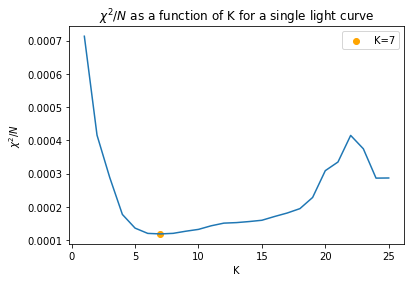

In [43]:
plt.figure()
plt.plot(K_values, chi_square_N)
plt.xlabel("K")
plt.ylabel(r"$\chi^2/N$")
plt.title(r"$\chi^2/N$ as a function of K for a single light curve")
plt.scatter(np.argmin(chi_square_N)+1, chi_square_N[np.argmin(chi_square_N)], color="orange",
           label="K=%s"%(np.argmin(chi_square_N)+1))
plt.legend()
plt.show()

In [44]:
best_K_value = np.argmin(chi_square_N)+1
print("The best K value based on this data is %s"%best_K_value)

The best K value based on this data is 7


The best order Fourier Series is K=7. This was the index that corresponds with the least value of $\chi^2/N$. This is important because it gives us a model that is neither underfitted, where it misses some detail in the structure, nor is it overfitted, where the model tries too hard to pass through each data point. 

# 1.8

In [45]:
def fourier_series(x, P, *a):
    """computes a complete series given array of
    coefficients *a"""
    #put together the sin terms first with degree+1 terms
    degree = len(a[0])//2
    w = 2*np.pi/P
    ret = a[0][0]
    for deg in range(1, degree+1):
        ret += a[0][deg]*np.sin((deg)*w*x)
        ret += a[0][deg+degree]*np.cos((deg)*w*x)
    return ret

In [46]:
fit_x, fit_y, coefficients = fourier_fit(phase, mag, est, 7)

In [47]:
# start_time = light_curve["time"][0]
# time_interval = light_curve["time"][-1] - light_curve["time"][0]
# end_time = start_time + time_interval

In [48]:
# x = np.linspace(start_time, end_time, num=10000)
# y = fourier_series(x, est, coefficients)
# fourier_model = fourier_series(light_curve["time"], est, coefficients)

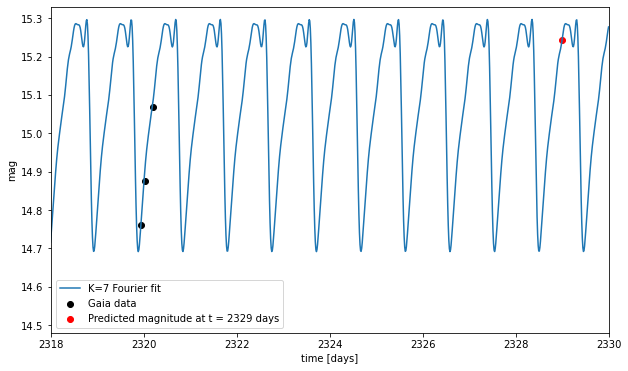

In [49]:
t = np.linspace(2318, 2330, num=1000)
prediction_time = 2329
fourier_model = fourier_series(t, est, coefficients)
predicted_mag = fourier_series(prediction_time, est, coefficients)

plt.figure(figsize=(10,6))
plt.scatter(light_curve["time"], light_curve["mag"], label="Gaia data", color="black")
plt.plot(t, fourier_model, label="K=%s Fourier fit"% best_K_value)
plt.scatter(prediction_time, predicted_mag, 
            label="Predicted magnitude at t = %s days"%prediction_time, color="red")
plt.xlim(2318, 2330)
plt.ylim(14.48, 15.33)
plt.legend()
plt.xlabel("time [days]")
plt.ylabel("mag")
plt.show()

# 1.9 

Table 1 of [this paper](https://www.aanda.org/articles/aa/full_html/2018/08/aa32756-18/aa32756-18.html?fbclid=IwAR0bGz7kqONgB-5_vQyHkZyxzO8PRPe6GWIA0RArjjsArTHX66NHxzjEru0#T2) gives the value for the zero point $G_Z$

In [50]:
def light_curve_to_mean_mag(light_curve, K):
    """takes in a light curve table of Gaia data and 
    computes the mean magnitude over one cycle"""
    period = get_period(light_curve)
    phase, mag, period = strip_units_but_better(light_curve["time"], light_curve["mag"], period)
    fit_x, fit_y, coeff = fourier_fit(phase, mag, period, K)
    t = np.linspace(0, period, num=1000)
    model_mag = fourier_series(t, period, coeff)
    mean_mag = np.log10(np.average(10**model_mag))
    data_mean_mag = np.log10(np.average(10**mag))
    return mean_mag, data_mean_mag

In [51]:
fourier_mean_mags = []
data_mean_mags = []

for lc in all_light_curves:
    fourier_mag, data_mag = light_curve_to_mean_mag(lc, 7)
    fourier_mean_mags.append(fourier_mag)
    data_mean_mags.append(data_mag)

In [52]:
def percent_difference(measured, real):
    return (real-measured)/real

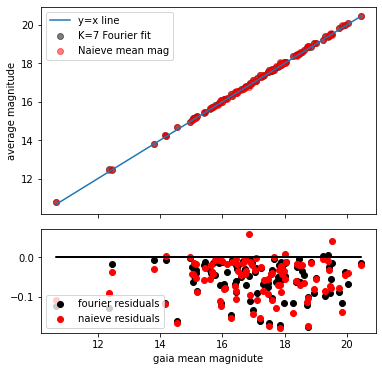

In [53]:
gaia_mean_mags = rr_lyrae_sample["int_average_g"]
residual_fourier = gaia_mean_mags - fourier_mean_mags
residual_data = gaia_mean_mags - data_mean_mags
fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios":[2,1]}, figsize=(6,6))
plt.subplots_adjust(hspace=0.1)

x = np.linspace(min(gaia_mean_mags), max(gaia_mean_mags))
y = x
ax1.scatter(gaia_mean_mags, fourier_mean_mags, color="black", label="K=%s Fourier fit"%7, alpha=0.5)
ax1.scatter(gaia_mean_mags, data_mean_mags, label="Naieve mean mag", alpha=0.5, color="red")
ax1.set_ylabel("average magnitude")
ax1.plot(x, y, label="y=x line")
ax1.legend()


ax2.scatter(gaia_mean_mags, residual_fourier, color="black", label="fourier residuals")
ax2.scatter(gaia_mean_mags, residual_data, color="red", label="naieve residuals")
ax2.plot(gaia_mean_mags, np.zeros(len(gaia_mean_mags)), color="black")
#ax2.set_ylim(-0.1, 0.1)
ax2.set_xlabel("index")
ax2.legend()
plt.xlabel("gaia mean magnidute")
plt.show()

In [54]:
def chs(observed, expected):
    return np.sum((observed-expected)**2/expected)

In [55]:
from scipy.stats import chisquare

When looking at the residuals of both the mean magnitude based on the fourier model and the mean magnitude taken directly from the raw data, we can see that they are both lower than the values given in the Gaia catalog. 

Although the residuals are lower, we can see that the Fourier residuals are distributed more closely to zero. 

# 1.10

In [56]:
RRc_query = """SELECT top 3 *
FROM gaiadr2.gaia_source
JOIN gaiadr2.vari_rrlyrae using (source_id)
WHERE int_average_g<15
AND best_classification='RRc'
AND num_clean_epochs_g>80"""

RRab_query = """SELECT top 3 *
FROM gaiadr2.gaia_source
JOIN gaiadr2.vari_rrlyrae using (source_id)
WHERE int_average_g<15
AND best_classification='RRab'
AND num_clean_epochs_g>80"""

RRc_tbl = get_gaia_query(RRc_query)
RRab_tbl= get_gaia_query(RRab_query)
len(RRc_tbl), len(RRab_tbl)

(3, 3)

In [57]:
RRc_light_curves = []
for url in RRc_tbl['epoch_photometry_url']:
    lc = light_curve_from_url(url, quality_cuts=True)
    RRc_light_curves.append(lc)
    
RRab_light_curves = []
for url in RRab_tbl['epoch_photometry_url']:
    lc = light_curve_from_url(url, quality_cuts=True)
    RRab_light_curves.append(lc)

In [58]:
RRc_periods = []
RRc_mags = []
RRc_phase = []

for lc in RRc_light_curves:
    r_period = get_period(lc)
    phase, mag, period = strip_units_but_better(lc["time"], lc["mag"], r_period)
    RRc_periods.append(period)
    RRc_mags.append(mag)
    RRc_phase.append(phase)
    
RRab_periods = []
RRab_mags = []
RRab_phase = []

for lc in RRab_light_curves:
    r_period = get_period(lc)
    phase, mag, period = strip_units_but_better(lc["time"], lc["mag"], r_period)
    RRab_periods.append(period)
    RRab_mags.append(mag)
    RRab_phase.append(phase)

In [59]:
def best_K_value(light_curve, max_K=25, plot_K=False):
    chi_square_N = []
    K_values = np.arange(1, max_K+1)
    est_period = get_period(light_curve)
    phase, mag, est = strip_units_but_better(light_curve["time"], light_curve["mag"], est_period)

    start = time.time()
    for k in K_values:
        #print("starting K=%s"%k)
        chi = chi_square_over_N(phase, mag, est, k, validation=True)
        chi_square_N.append(chi)
    #print("\n\nthis took %s seconds"%(time.time()-start))
    
    if plot_K:
        plt.figure()
        plt.plot(K_values, chi_square_N)
        plt.xlabel("K")
        plt.ylabel(r"$\chi^2/N$")
        plt.title(r"$\chi^2/N$ as a function of K for a single light curve")
        plt.scatter(np.argmin(chi_square_N)+1, chi_square_N[np.argmin(chi_square_N)], color="orange",
               label="K=%s"%(np.argmin(chi_square_N)+1))
        plt.legend()
        plt.show()
        
    best_K = np.argmin(chi_square_N)+1
    print("The best K value based on this data is %s"%best_K)
    return best_K

### RRc phased light curves

To determine the appropriate K value, I minimized $\chi^2/N$ as a function of K for each plot and used the K value that minimized it. 

In [60]:
RRc_light_curves[0][:5]

source_id,transit_id,band,time,mag,flux,flux_error,flux_over_error,rejected_by_photometry,rejected_by_variability,other_flags,solution_id
,,,d,mag,e-/s,e-/s,,,,,
int64,int64,object,float64,float64,float64,float64,float32,bool,bool,int64,int64
6062122282811812480,16788309982344201,G,1700.4505002749781,14.565017158629132,28140.99354758843,49.93716726119283,563.528,False,False,4097,369295549951641967
6062122282811812480,16792402274079143,G,1700.5245023980992,14.592284433818827,27443.058823853764,28.360203755272305,967.6608,False,False,1,369295549951641967
6062122282811812480,18692866272310886,G,1734.8915003539896,14.31080268418775,35565.19681342092,39.51327152841465,900.08234,False,False,1,369295549951641967
6062122282811812480,21274212922861322,G,1781.5730816980356,14.327808817379495,35012.471079012816,42.59610720513835,821.9641,False,False,524289,369295549951641967
6062122282811812480,21283953831977148,G,1781.7492502491755,14.57324692443079,27928.494166443434,39.435336030548456,708.20984,False,False,1,369295549951641967


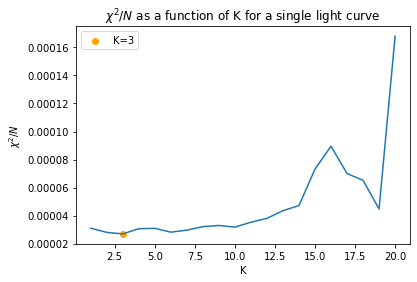

The best K value based on this data is 3


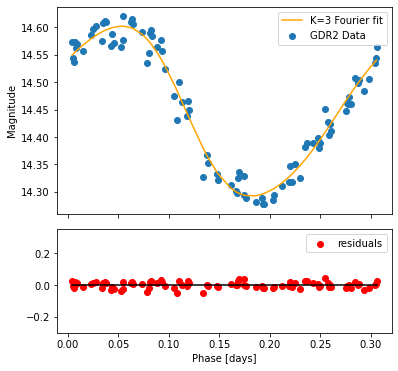

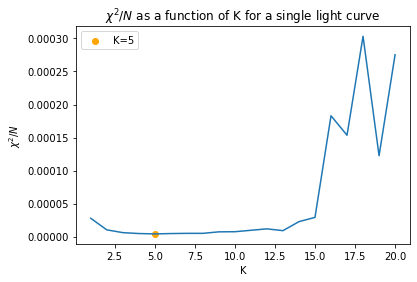

The best K value based on this data is 5


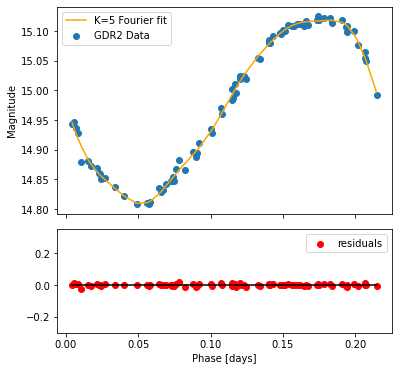

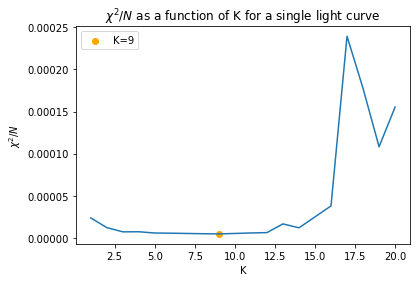

The best K value based on this data is 9


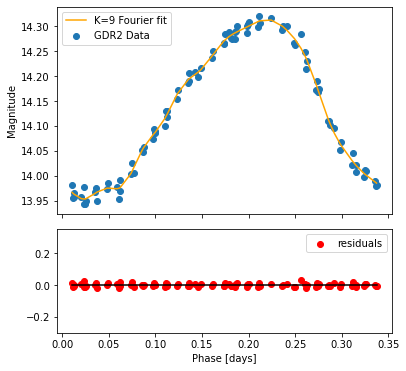

In [61]:
for i in range(len(RRc_light_curves)):
    choice_K = best_K_value(RRc_light_curves[i], max_K=20, plot_K=True)
    plot_fourier_fit(RRc_phase[i], RRc_mags[i], RRc_periods[i], choice_K, residuals=True)

### RRab phased light curves

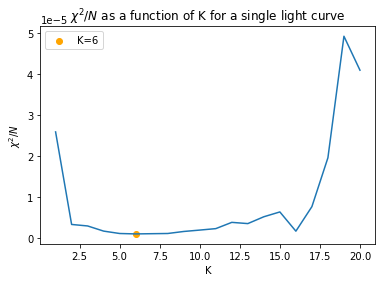

The best K value based on this data is 6


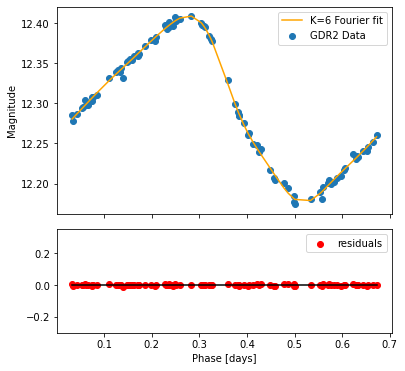

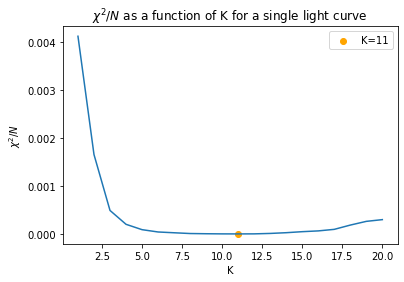

The best K value based on this data is 11


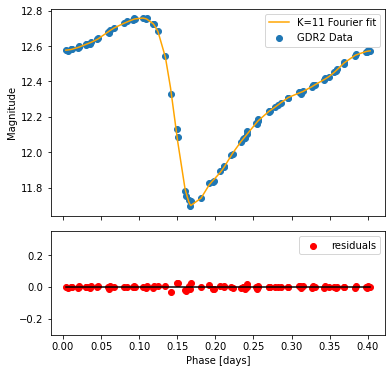

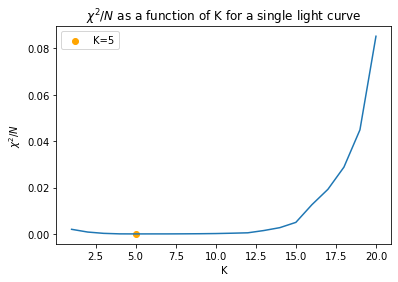

The best K value based on this data is 5


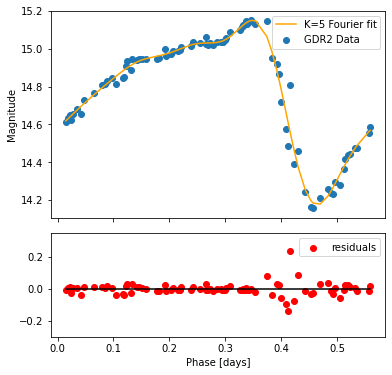

In [62]:
for i in range(len(RRab_light_curves)):
    choice_K = best_K_value(RRab_light_curves[i], max_K=20, plot_K=True)
    plot_fourier_fit(RRab_phase[i], RRab_mags[i], RRab_periods[i], choice_K, residuals=True)

Looking at the phased light curves of RRc and RRab classes, we can see some differences in the shape of the light curves. When looking at the RRc class, we can see that the phased light curve has a more smoothly varying brighness when compared to the RRac class. The class RRab has a sharp decrease in magnitude (increase in brightness) over a period of 2-5 hours (roughly 25% of a cycle), while the RRc class has an increase in brighness that takes about 50% of its cycle.

# 1.11 

In [63]:
def p_diff(p1, p2):
    """this calculates the percentage difference
    betrween the two numbers"""
    return np.abs(p1-p2)/np.average([p1, p2])

In [64]:
print("The RRc periods in days are:\n", RRc_periods)
print("\nThe percentage difference between each of the star's pulsation periods are:")
p_diff(RRc_periods[0], RRc_periods[1]), p_diff(RRc_periods[1], RRc_periods[2]), p_diff(RRc_periods[0], RRc_periods[2])

The RRc periods in days are:
 [0.3056165873795714, 0.21688100790271397, 0.33781176725876855]

The percentage difference between each of the star's pulsation periods are:


(0.3396592837098782, 0.4360278870437753, 0.10007386105106755)

In [65]:
print("The RRc periods in days are:\n", RRab_periods)
print("\nThe percentage difference between each of the star's pulsation periods are:")
p_diff(RRab_periods[0], RRab_periods[1]), p_diff(RRab_periods[1], RRab_periods[2]), p_diff(RRab_periods[0], RRab_periods[2])

The RRc periods in days are:
 [0.6739930939414713, 0.41159205918050734, 0.5618881071165899]

The percentage difference between each of the star's pulsation periods are:


(0.48342782508831905, 0.30878091437193916, 0.18141709207795417)

Looking at the periods of both classes, it does not appear that there is a single period that describes them all. When comparing the periods of the RRc class, the periods differ between 10% and 43%, and the RRab class periods differ between 18% and 48%. 

The variation in the RRc stars can be attributed to the Blazhko effect, which is a longer period birghtness modulation, beyond the first overtone, which are hard to observe in a single pulsation period of the fist overtone. Proposed explanations for the long period modulations are a possible resonance with a higer pulsation mode [Buchler and Kollath, 2011](https://arxiv.org/abs/1101.1502), or cycles in convection that affect the modulations [Stothers 2010](https://iopscience.iop.org/article/10.1086/652909). 

# 1.12 

In order to accurately determine the distance to sources in the Gaia catalog, we need sources with little dust between us and the source. The lack of dust is important because dust reduces the flux we receive from the source, increasing the apparent magnitude of the source ($G$ below).

$M_G = G - 5log_{10}(d/10)$ where $d$ is the distance in parsecs.

If the dust is not accounted for, the absolute magnitude will be calculated as higher than its true value. To avoid the complications introduced by correcting for extinction, we will use sources which are found in regions of the sky that are known to have minimal dust in the line of sight. 

Query informed by this [Gaia example](https://gea.esac.esa.int/archive-help/adql/examples/index.html)

In [66]:
minimal_dust_query = """SELECT gaia.source_id as dr3_id, 
gaia.parallax as dr3_parallax, gaia.parallax_error as dr3_parallax_error,
gaia2.parallax as dr2_parallax, gaia2.parallax_error as dr2_parallax_error,
gaia.ra as dr3_ra, gaia.dec as dr3_dec, vari.source_id as dr2_id, vari.*
FROM gaiaedr3.gaia_source AS gaia
INNER JOIN gaiaedr3.dr2_neighbourhood AS xmatch ON gaia.source_id = xmatch.dr3_source_id
INNER JOIN gaiadr2.vari_rrlyrae AS vari ON vari.source_id = xmatch.dr2_source_id
INNER JOIN gaiadr2.gaia_source AS gaia2 ON gaia2.source_id = xmatch.dr2_source_id
WHERE gaia.parallax_over_error>5
AND abs(gaia.b)>30
AND gaia.parallax>0.25
AND gaia2.parallax>0.25"""

minimal_dust_table = get_gaia_query(minimal_dust_query)
len(minimal_dust_table)

610

In [67]:
minimal_dust_table[:5]

dr3_id,dr3_parallax,dr3_parallax_error,dr2_parallax,dr2_parallax_error,dr3_ra,dr3_dec,dr2_id,solution_id,source_id,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification
,mas,mas,mas,mas,deg,deg,,,,d,d,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,dex,dex,,,,,rad,rad,rad,rad,,,,mag,mag,
int64,float64,float32,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,object
1584980409832992000,0.31686490296159797,0.017345669,0.2790668790229806,0.022067382424739896,183.12629580582893,65.50636231090792,1584980409832992000,369295549951641967,1584980409832992000,--,--,0.3490563463564651,7.334743694784753e-08,--,--,--,--,1703.1077064268932,1.0372894009695144e-07,1703.108369836907,1.0372894009695144e-07,1703.1154709232442,1.0372894009695144e-07,13.007955587004306,0.00011986018305241369,13.14563406393534,0.0004014237450362405,12.731253312599428,0.0004025739704284215,0.5989991085122739,0.00037128620363793716,0.6899717621171284,0.0017085152490401816,0.43415798794149474,0.0018758970958496434,--,--,0.2883225202949067,0.0009918534810781673,--,--,4.534289448501163,0.002285024991056731,--,--,29,28,27,--,--,RRc
4657904848780392832,2.1172031336606514,0.41779542,0.9676799732849048,0.4335785091339989,82.16325633206633,-70.1176998187946,4657904848780391296,369295551293819386,4657904848780391296,0.4340093914687051,1.3034820643188162e-05,--,--,--,--,--,--,1694.9990419634328,1.843402013669749e-05,1694.9990419634328,1.843402013669749e-05,1694.9990419634328,1.843402013669749e-05,19.55852831331493,0.01993114010623052,--,--,--,--,0.9139714328949999,0.07025704556033079,--,--,--,--,--,--,0.3335872940913979,0.1186356662263504,--,--,4.399535473599808,2.036204377429382,--,--,18,6,6,--,--,RRab
4685757887726594816,0.3309123727206872,0.012480282,0.31373396498611444,0.02225346497165527,11.233266580284809,-73.88076610780682,4685757887726594816,369295551293819386,4685757887726594816,0.7328986984075784,2.210916947336303e-07,--,--,--,--,--,--,1700.1515422599432,3.126708732203522e-07,1700.175357740917,3.126708732203522e-07,1700.164394595709,3.126708732203522e-07,12.539364741401702,0.00018942678268851196,12.798629401936806,0.0011800342042820224,12.1317779575876,0.0011307200011852515,0.5037185699362237,0.00107535211572678,0.5506303193073361,0.005012904549156718,0.4816255923669672,0.01064715969609323,-1.932377257682667,0.21757864740437552,0.44031740350988585,0.001006065571948051,0.2851632741563908,0.0007669056732438964,4.133242402093934,0.002063515429957707,2.2544282689567527,0.00594205497209144,29,25,22,0.03512664480618247,0.05116170220558907,RRab
4689637956899105792,0.4975217097990588,0.043104377,0.466748298647083,0.046681007177642134,5.9190552532535845,-72.09999856807035,4689637956899105792,369295551293819386,4689637956899105792,0.737200476500502,6.198578236434062e-07,--,--,--,--,--,--,1701.1898494650725,8.766113409395753e-07,1741.8389782677316,8.766113409395753e-07,1741.8471082250373,8.766113409395753e-07,13.571605430460439,0.0008351521844017546,13.835552292091958,0.009909228186030317,13.230225260684257,0.006586162173929821,0.92472238616166,0.00211125403266523,0.7051533008236799,0.02434661409988613,0.45657671779703435,0.017933760

In [68]:
count_changed = np.sum((minimal_dust_table["dr3_id"] - minimal_dust_table["dr2_id"]) != 0)
print("There were %s sources in this samle that had their source id change from dr2 to edr3"%count_changed)

There were 45 sources in this samle that had their source id change from dr2 to edr3


[Torra et al. 2020](https://arxiv.org/pdf/2012.06420.pdf) offers explanations for why some source IDs changed. The first explanation is that some sources did not have good enough proper motion data to be included in the earlier data release and the second explanation is that the XM algorithm did not have a good enough proper motion measure and created several different source entries that belong to the same source. 

# 1.13 

In [69]:
geo_distance_query = """SELECT gaia.source_id as dr3_id, gaia2.source_id as dr2_id,
dist.r_med_geo, dist.r_hi_geo, dist.r_lo_geo, gaia.ra as dr3_ra, gaia.dec as dr3_dec,
gaia.parallax as dr3_parallax,gaia.parallax_error as dr3_parallax_error, 
gaia2.parallax as dr2_parallax, gaia2.parallax_error as dr2_parallax_error,
gaia2.phot_g_mean_mag, vari.pf, vari.pf_error
FROM gaiaedr3.gaia_source as gaia
INNER JOIN external.gaiaedr3_distance AS dist ON gaia.source_id = dist.source_id
INNER JOIN gaiaedr3.dr2_neighbourhood AS xmatch ON gaia.source_id = xmatch.dr3_source_id
INNER JOIN gaiadr2.gaia_source AS gaia2 ON gaia2.source_id = xmatch.dr2_source_id
INNER JOIN gaiadr2.vari_rrlyrae AS vari ON vari.source_id = xmatch.dr2_source_id
WHERE gaia.parallax_over_error>5
AND abs(gaia.b)>30
AND gaia.parallax>0.25
AND gaia2.parallax>0.25
AND vari.pf IS NOT NULL"""

geo_distance_table = get_gaia_query(geo_distance_query)
len(geo_distance_table)

403

In [70]:
geo_distance_table[:5]

dr3_id,dr2_id,r_med_geo,r_hi_geo,r_lo_geo,dr3_ra,dr3_dec,dr3_parallax,dr3_parallax_error,dr2_parallax,dr2_parallax_error,phot_g_mean_mag,pf,pf_error
,,pc,pc,pc,deg,deg,mas,mas,mas,mas,mag,d,d
int64,int64,float32,float32,float32,float64,float64,float64,float32,float64,float64,float32,float64,float64
4657904848780392832,4657904848780391296,519.09235,643.45966,404.28738,82.16325633206633,-70.1176998187946,2.1172031336606514,0.41779542,0.9676799732849048,0.4335785091339989,19.554853,0.4340093914687051,1.3034820643188162e-05
4685757887726594816,4685757887726594816,2833.865,2955.3726,2740.6484,11.233266580284809,-73.88076610780682,0.3309123727206872,0.012480282,0.31373396498611444,0.02225346497165527,12.586509,0.7328986984075784,2.210916947336303e-07
4689637956899105792,4689637956899105792,1837.7812,2005.7107,1696.2314,5.9190552532535845,-72.09999856807035,0.4975217097990588,0.043104377,0.466748298647083,0.046681007177642134,13.809466,0.737200476500502,6.198578236434062e-07
4689637961175354240,4689637956899105792,362.1498,465.05887,306.89264,5.918276032499516,-72.10036420772356,2.948479583163598,0.49615088,0.466748298647083,0.046681007177642134,13.809466,0.737200476500502,6.198578236434062e-07
4700326863447344768,4700326863447344768,196.10782,205.43623,187.60051,39.28563100978933,-63.116401456841714,5.211784254751428,0.23457597,4.7553237843037275,0.5069283508514554,17.800022,0.620386485557501,8.299791738461235e-06


# 1.14 

In [71]:
from astropy.coordinates import SkyCoord
#from astropy.coordinates import sky_offset_frame
import astropy.coordinates as coord

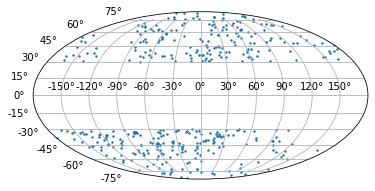

In [72]:
gal = SkyCoord(geo_distance_table["dr3_ra"], geo_distance_table["dr3_dec"], frame="icrs", unit=u.deg,).galactic

plt.subplot(111, projection="mollweide")
plt.grid(True)
plt.scatter(gal.l.wrap_at("180d").radian, gal.b.radian, s=2)

In [73]:
bailer_jones_distance = geo_distance_table["r_med_geo"]
dr3_naieve_distance = 1000/geo_distance_table["dr3_parallax"]
dr2_naieve_distance = 1000/geo_distance_table["dr2_parallax"]
dr3_diff = bailer_jones_distance - dr3_naieve_distance
dr2_diff = bailer_jones_distance - dr2_naieve_distance

In [74]:
tbl_contents = {"bailer_jones":bailer_jones_distance, 
                "dr3_naieve":dr3_naieve_distance,
                "dr3_difference":dr3_diff,
                "dr2_naieve":dr2_naieve_distance,
                "dr2_difference":dr2_diff}
df = pd.DataFrame(tbl_contents)

In [75]:
df.sort_values("bailer_jones")

,bailer_jones,dr3_naieve,dr3_difference,dr2_naieve,dr2_difference
294,109.551369,104.779309,4.772060,1829.876829,-1720.325460
187,167.027649,136.223403,30.804246,123.759124,43.268525
172,175.048416,161.871176,13.177241,929.044823,-753.996407
291,194.926743,178.196570,16.730173,95.782005,99.144738
4,196.107819,191.872869,4.234949,210.290623,-14.182804
...,...,...,...,...,...
195,3444.413574,3932.178530,-487.764956,3263.577107,180.836467
329,3449.535156,3927.331052,-477.795896,3879.715493,-430.180337
113,3468.951416,3951.244641,-482.293225,3664.571529,-195.620113
49,3503.297119,3896.329457,-393.032338,3871.374941,-368.077822


We will plot the naieve distance $(parallax)^{-1}$ against the Bailer-Jones distance to see how the compare to each other. We can see that the distance estimated naievely by taking the inverse of the parallax gives us a greater distance, as the distance to the source increases (parallax decreases). This increse in the naieve distance can be attributed to the increasing errors in the parallax measurement due to dim sources and less accurate parallax measurements. The Bailer-Jones distance ([Bailer-Jones et al. 2020](https://arxiv.org/pdf/2012.05220.pdf)) takes the geometric distance (parallax), in addition to the photogeometric distance, which accounts for the color and magnitude of a star. They combine these to form a prior on the distance of the star, which they go on to estimate using Metropolis MCMC algorithm. 

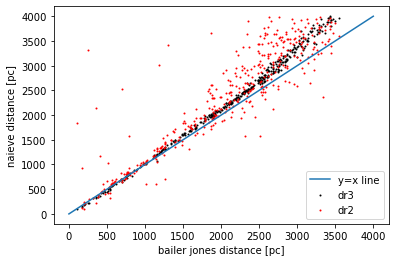

In [76]:
plt.figure()
x = np.linspace(0, 4000)
y = x
plt.plot(x, y, label="y=x line")
plt.scatter(df["bailer_jones"], df["dr3_naieve"],s=1,color="black", label="dr3")
plt.scatter(df["bailer_jones"], df["dr2_naieve"],s=1,color="red", label="dr2")
plt.xlabel("bailer jones distance [pc]")
plt.ylabel("naieve distance [pc]")
plt.legend()
plt.show()

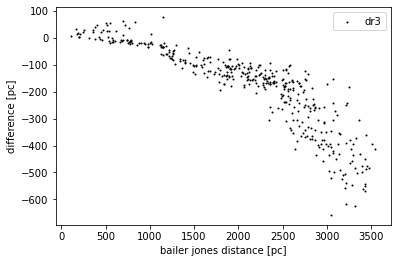

In [77]:
plt.figure()
plt.scatter(df["bailer_jones"], df["dr3_difference"],s=1,color="black", label="dr3")
#plt.scatter(df["bailer_jones"], df["dr2_difference"],s=1,color="red", label="dr2")
plt.xlabel("bailer jones distance [pc]")
plt.ylabel("difference [pc]")
plt.legend()
plt.show()

The difference between the Bailer-Jones distance and the naieve distance increases as the distance of the source gets larger. 

Text(0, 0.5, 'dr2 parallax [mas]')

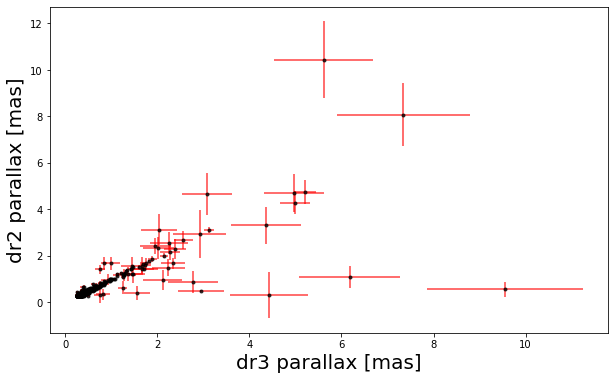

In [78]:
plt.figure(figsize=(10,6))
#plt.scatter(geo_distance_table["dr3_parallax"], geo_distance_table["dr2_parallax"], color="blue")
plt.errorbar(geo_distance_table["dr3_parallax"], geo_distance_table["dr2_parallax"],
             yerr=geo_distance_table["dr2_parallax_error"],
             xerr=geo_distance_table["dr3_parallax_error"], fmt=".k", alpha=0.75, ecolor="red")
plt.xlabel("dr3 parallax [mas]", fontsize=20)
plt.ylabel("dr2 parallax [mas]", fontsize=20)

In [79]:
dr3_average_uncertainty = np.average(geo_distance_table["dr3_parallax_error"])
dr2_average_uncertainty = np.average(geo_distance_table["dr2_parallax_error"])
difference = dr2_average_uncertainty - dr3_average_uncertainty
print("The average uncertainty in the dr2 parallax is %s mas"%dr2_average_uncertainty, 
      "and the average uncertainty in the dr3 parallax is %s mas."%dr3_average_uncertainty,
     "The dr3 average error is smaller by %s mas"%difference)

The average uncertainty in the dr2 parallax is 0.07887841177818647 mas and the average uncertainty in the dr3 parallax is 0.059915992225665904 mas. The dr3 average error is smaller by 0.018962419552520565 mas


# 1.15

The distance modulus fomula allows us to change between apparent magnitude (what Gaia reports) and absolute magnitude using the distance to the source. The formula is as follows:


$M = m - 5log_{10}(\frac{d}{10}) \hspace{.6cm}$ where $d$ is the distance in parsecs.

In [80]:
geo_distance_table[:5]

dr3_id,dr2_id,r_med_geo,r_hi_geo,r_lo_geo,dr3_ra,dr3_dec,dr3_parallax,dr3_parallax_error,dr2_parallax,dr2_parallax_error,phot_g_mean_mag,pf,pf_error
,,pc,pc,pc,deg,deg,mas,mas,mas,mas,mag,d,d
int64,int64,float32,float32,float32,float64,float64,float64,float32,float64,float64,float32,float64,float64
4657904848780392832,4657904848780391296,519.09235,643.45966,404.28738,82.16325633206633,-70.1176998187946,2.1172031336606514,0.41779542,0.9676799732849048,0.4335785091339989,19.554853,0.4340093914687051,1.3034820643188162e-05
4685757887726594816,4685757887726594816,2833.865,2955.3726,2740.6484,11.233266580284809,-73.88076610780682,0.3309123727206872,0.012480282,0.31373396498611444,0.02225346497165527,12.586509,0.7328986984075784,2.210916947336303e-07
4689637956899105792,4689637956899105792,1837.7812,2005.7107,1696.2314,5.9190552532535845,-72.09999856807035,0.4975217097990588,0.043104377,0.466748298647083,0.046681007177642134,13.809466,0.737200476500502,6.198578236434062e-07
4689637961175354240,4689637956899105792,362.1498,465.05887,306.89264,5.918276032499516,-72.10036420772356,2.948479583163598,0.49615088,0.466748298647083,0.046681007177642134,13.809466,0.737200476500502,6.198578236434062e-07
4700326863447344768,4700326863447344768,196.10782,205.43623,187.60051,39.28563100978933,-63.116401456841714,5.211784254751428,0.23457597,4.7553237843037275,0.5069283508514554,17.800022,0.620386485557501,8.299791738461235e-06


$M = m = 5log_{10}(d/10) \to \Delta M = 5 \cfrac{\Delta d}{d}$ 

Text(0, 0.5, 'absolute magnitude')

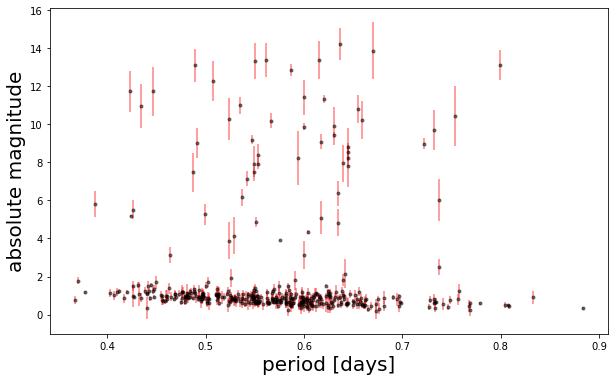

In [81]:
M = geo_distance_table["phot_g_mean_mag"] - 5*np.log10(geo_distance_table["r_med_geo"]/10)
symmetrized_error = (geo_distance_table["r_hi_geo"] - geo_distance_table["r_lo_geo"])/2
pf_err = geo_distance_table["pf_error"]
M_err = 2.5*(geo_distance_table["r_hi_geo"] - geo_distance_table["r_lo_geo"])/geo_distance_table["r_med_geo"]


plt.figure(figsize=(10,6))
plt.errorbar(geo_distance_table["pf"], M, yerr=M_err, xerr=pf_err,
             fmt=".k", alpha=0.5, ecolor="red")
plt.xlabel("period [days]", fontsize=20)
plt.ylabel("absolute magnitude", fontsize=20)

# 1.16

There was a high scatter in the absolute magnitudes calculated above, so I implemented the quality cuts from equations C1 and C2 from [Lindegren et al. 2018](https://arxiv.org/abs/1804.09366) to remove sources with high uncertainty in the measurements. 

In [82]:
quality_cuts_query = """SELECT gaia.source_id as dr3_id, gaia2.source_id as dr2_id,
dist.r_med_geo, dist.r_hi_geo, dist.r_lo_geo, gaia.ra as dr3_ra, gaia.dec as dr3_dec,
gaia.parallax as dr3_parallax,gaia.parallax_error as dr3_parallax_error, 
gaia2.parallax as dr2_parallax, gaia2.parallax_error as dr2_parallax_error,
gaia2.phot_g_mean_mag as G, vari.pf, vari.pf_error,
sqrt(gaia2.astrometric_chi2_al/(gaia2.astrometric_n_good_obs_al - 5)) AS u,
gaia2.bp_rp, gaia.phot_g_mean_mag, gaia2.phot_bp_mean_mag, gaia2.phot_rp_mean_mag,
gaia2.phot_g_mean_flux_error, gaia2.phot_bp_mean_flux_error, gaia2.phot_rp_mean_flux_error,
gaia2.phot_g_mean_flux_over_error, gaia2.phot_bp_mean_flux_over_error, gaia2.phot_rp_mean_flux_over_error,
gaia2.phot_g_mean_flux, gaia2.phot_bp_mean_flux, gaia2.phot_rp_mean_flux
FROM gaiaedr3.gaia_source as gaia
INNER JOIN external.gaiaedr3_distance AS dist ON gaia.source_id = dist.source_id
INNER JOIN gaiaedr3.dr2_neighbourhood AS xmatch ON gaia.source_id = xmatch.dr3_source_id
INNER JOIN gaiadr2.gaia_source AS gaia2 ON gaia2.source_id = xmatch.dr2_source_id
INNER JOIN gaiadr2.vari_rrlyrae AS vari ON vari.source_id = xmatch.dr2_source_id
WHERE gaia.parallax_over_error>5
AND abs(gaia.b)>30
AND gaia.parallax>0.25
AND gaia2.parallax>0.25
AND vari.pf IS NOT NULL
AND 1.0 + 0.015*POWER(gaia2.bp_rp, 2) < gaia2.phot_bp_rp_excess_factor 
AND gaia2.phot_bp_rp_excess_factor < 1.3 + 0.06*POWER(gaia2.bp_rp, 2)"""

quality_cuts_table = get_gaia_query(quality_cuts_query)
bools = []

for i in np.arange(len(quality_cuts_table)):
    result = quality_cuts_table['u'][i] < 1.2*np.max([1, np.exp(-0.2*(quality_cuts_table["g"][i] - 19.5))])
    bools.append(result)
    
quality_cuts_table = quality_cuts_table[bools]
len(quality_cuts_table)

352

In [83]:
quality_cuts_table[:5]

dr3_id,dr2_id,r_med_geo,r_hi_geo,r_lo_geo,dr3_ra,dr3_dec,dr3_parallax,dr3_parallax_error,dr2_parallax,dr2_parallax_error,g,pf,pf_error,u,bp_rp,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux
,,pc,pc,pc,deg,deg,mas,mas,mas,mas,mag,d,d,,mag,mag,mag,mag,electron / s,electron / s,electron / s,,,,electron / s,electron / s,electron / s
int64,int64,float32,float32,float32,float64,float64,float64,float32,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float32,float32,float32,float64,float64,float64
4685757887726594816,4685757887726594816,2833.865,2955.3726,2740.6484,11.233266580284809,-73.88076610780682,0.3309123727206872,0.012480282,0.31373396498611444,0.02225346497165527,12.586509,0.7328986984075784,2.210916947336303e-07,1.3345154202959506,0.689024,12.557787,12.839874,12.15085,1157.9326738966517,2657.4567143960307,1862.4550022327373,150.33473,38.031136,59.47607,174077.49459461196,101066.09875599104,110771.50285217099
4793950312913699328,4793950312913699328,2563.536,2644.5483,2491.1633,84.96203078396498,-49.42814117443551,0.3711630341537675,0.013272379,0.2809782888456447,0.017400227901490622,12.946365,0.6102558420766953,2.0550550272740676e-07,1.285616795310239,0.6847296,12.900876,13.207869,12.523139,913.2832800996628,1901.7481394918973,1241.5665541058086,136.8342,37.86646,63.320206,124968.38131035703,72012.46480895128,78616.2485813695
6275283468151655424,6275283468151655424,3025.0488,3207.802,2883.0452,210.71536409582114,-24.071768493399738,0.2889588235635974,0.017614072,0.27733097268923157,0.028567784963639212,13.774176,0.46293095826261343,2.0152837216130544e-07,0.9671694214490262,0.6809864,13.775085,14.038564,13.357577,681.5164722533377,1449.328931126198,1094.0977927658919,85.54599,23.118666,33.318165,58301.00141615385,33506.55198699923,36453.32959484706
6321036891467501952,6321036891467501952,2104.1118,2186.5425,2006.1956,230.7006634391497,-8.366211767095717,0.45047662580026865,0.016339941,0.4631321386531367,0.037470624912400684,12.468434,0.6074482218867095,3.295367417031305e-07,1.261503502404321,0.70791435,12.453366,12.740816,12.032902,2080.121268355226,4577.038728781631,2865.869920130196,93.3005,24.190456,43.087467,194076.35740194676,110720.65284767127,123483.07148699572
6327036861995922560,6327036861995922560,3035.6802,3207.5933,2857.4646,222.5886563367257,-9.097310102960652,0.2916119349556604,0.018847315,0.32170454751901223,0.028733566255264246,13.028171,0.6438927625868223,5.984427221020134e-07,1.2616067242531754,0.7098627,13.007423,13.2919445,12.582082,1470.7576582634504,3127.647706305267,1956.1655215343676,78.80196,21.308834,38.065346,115898.58635973785,66646.52480302226,74462.11455381016


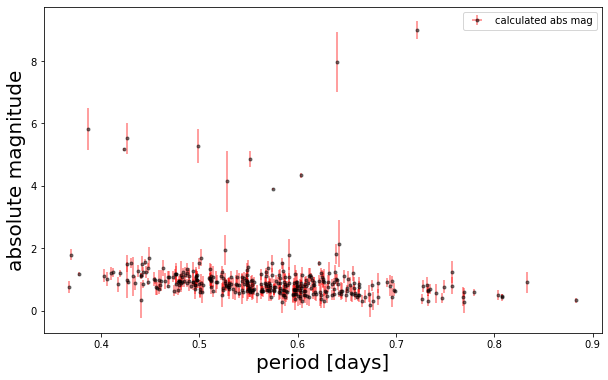

In [84]:
M = quality_cuts_table["g"] - 5*np.log10(quality_cuts_table["r_med_geo"]/10)
symmetrized_error = (quality_cuts_table["r_hi_geo"] - quality_cuts_table["r_lo_geo"])/2
#M_err = 5*np.log10(symmetrized_error/10)
M_err = np.sqrt(quality_cuts_table["phot_g_mean_flux_over_error"]**-2 + (5*(quality_cuts_table["r_hi_geo"] - quality_cuts_table["r_lo_geo"])/(2*quality_cuts_table["r_med_geo"]))**2)
pf_err = quality_cuts_table["pf_error"]
#ian's suggestion 
#log(1/r_lo - 1/log_hi)

plt.figure(figsize=(10,6))
plt.errorbar(quality_cuts_table["pf"], M, yerr=M_err, xerr=pf_err, fmt=".k", alpha=0.5, ecolor="red", label="calculated abs mag")
plt.xlabel("period [days]", fontsize=20)
plt.ylabel("absolute magnitude", fontsize=20)
plt.legend()
plt.show()

# 1.17

Most of the scatter was removed, but there are still some sources that are outliers. I will remove these by "sigma clipping" the values that are outside one standard deviation from the mean.

In [85]:
def magnitude_cut(M):
    std = np.std(M)
    mean = np.average(M)
    keep_indices = np.where((M > mean-std) & (M < mean+std))
    return keep_indices[0]

In [86]:
cut_index = magnitude_cut(M)
len(cut_index)

340

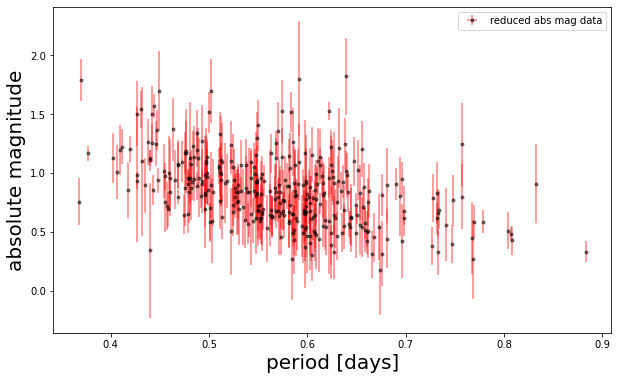

In [87]:
M = quality_cuts_table["g"] - 5*np.log10(quality_cuts_table["r_med_geo"]/10)
symmetrized_error = (quality_cuts_table["r_hi_geo"] - quality_cuts_table["r_lo_geo"])/2
#M_err = 5*np.log10(symmetrized_error/10)
M_err = np.sqrt(quality_cuts_table["phot_g_mean_flux_over_error"]**-2 + (5*(quality_cuts_table["r_hi_geo"] - quality_cuts_table["r_lo_geo"])/(2*quality_cuts_table["r_med_geo"]))**2)
pf_err = quality_cuts_table["pf_error"]

plt.figure(figsize=(10,6))
plt.errorbar(quality_cuts_table["pf"][cut_index], M[cut_index], yerr=M_err[cut_index], xerr=pf_err[cut_index], 
             fmt=".k", alpha=0.5, ecolor="red", label="reduced abs mag data")
plt.xlabel("period [days]", fontsize=20)
plt.ylabel("absolute magnitude", fontsize=20)
plt.legend()
plt.show()

# 1.18

Repeating the above plots with the gaia dr2 geometric distance catalog instead of the edr3 distance catalog

In [88]:
dr2_quality_cuts_query = "SELECT dist2.*, gaia3.source_id as edr3_id, gaia2.source_id as dr2_id, \
dist2.source_id as dist2_source_id, dist3.source_id as dist3_source_id, \
dist3.r_med_geo, dist3.r_hi_geo, dist3.r_lo_geo, gaia3.ra as edr3_ra, gaia3.dec as edr3_dec, \
gaia3.parallax as edr3_parallax,gaia3.parallax_error as edr3_par_err, \
gaia3.phot_g_mean_flux_over_error, \
gaia2.parallax as dr2_parallax, gaia2.parallax_error as dr2_par_err, \
gaia2.phot_g_mean_mag as dr2_mag, rr.pf as rr_pf, rr.pf_error as rr_pf_error, \
sqrt(gaia2.astrometric_chi2_al/(gaia2.astrometric_n_good_obs_al - 5)) AS u, \
gaia2.bp_rp, gaia2.phot_g_mean_mag, gaia2.phot_bp_mean_mag, gaia2.phot_rp_mean_mag \
FROM gaiaedr3.gaia_source as gaia3 \
INNER JOIN external.gaiaedr3_distance AS dist3 ON gaia3.source_id = dist3.source_id \
INNER JOIN gaiaedr3.dr2_neighbourhood AS neigh ON gaia3.source_id = neigh.dr3_source_id \
INNER JOIN gaiadr2.gaia_source AS gaia2 ON gaia2.source_id = neigh.dr2_source_id \
INNER JOIN gaiadr2.vari_rrlyrae AS rr ON rr.source_id = neigh.dr2_source_id \
INNER JOIN external.gaiadr2_geometric_distance AS dist2 ON dist2.source_id = gaia2.source_id \
WHERE gaia3.parallax_over_error>5 \
AND abs(gaia3.b)>30 \
AND gaia3.parallax>0.25 \
AND gaia2.parallax>0.25 \
AND rr.pf IS NOT NULL \
AND gaia3.parallax IS NOT NULL \
AND gaia2.parallax IS NOT NULL \
AND 1.0 + 0.015*POWER(gaia2.bp_rp, 2) < gaia2.phot_bp_rp_excess_factor \
AND gaia2.phot_bp_rp_excess_factor < 1.3 + 0.06*POWER(gaia2.bp_rp, 2);"

dr2_quality_cuts_table = get_gaia_query(dr2_quality_cuts_query)
bools = []

for i in np.arange(len(dr2_quality_cuts_table)):
    result = dr2_quality_cuts_table['u'][i] < 1.2*np.max([1, np.exp(-0.2*(dr2_quality_cuts_table["dr2_mag"][i] - 19.5))])
    bools.append(result)
    
dr2_quality_cuts_table = dr2_quality_cuts_table[bools]

len(dr2_quality_cuts_table)

352

In [89]:
dr2_quality_cuts_table[:5]

source_id,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,edr3_id,dr2_id,dist2_source_id,dist3_source_id,r_med_geo,r_hi_geo,r_lo_geo,edr3_ra,edr3_dec,edr3_parallax,edr3_par_err,phot_g_mean_flux_over_error,dr2_parallax,dr2_par_err,dr2_mag,rr_pf,rr_pf_error,u,bp_rp,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag
,pc,pc,pc,pc,,,,,,,pc,pc,pc,deg,deg,mas,mas,,mas,mas,mag,d,d,,mag,mag,mag,mag
int64,float64,float64,float64,float64,int16,int16,int64,int64,int64,int64,float32,float32,float32,float64,float64,float64,float32,float32,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32
4685757887726594816,2884.41569404887,2708.76681071371,3083.49935802086,604.698977736792,1,1,4685757887726594816,4685757887726594816,4685757887726594816,4685757887726594816,2833.865,2955.3726,2740.6484,11.233266580284809,-73.88076610780682,0.3309123727206872,0.012480282,153.29099,0.31373396498611444,0.02225346497165527,12.586509,0.7328986984075784,2.210916947336303e-07,1.3345154202959506,0.689024,12.586509,12.839874,12.15085
4793950312913699328,3182.64660438992,3014.25811272449,3370.20879142215,498.439106134319,1,1,4793950312913699328,4793950312913699328,4793950312913699328,4793950312913699328,2563.536,2644.5483,2491.1633,84.96203078396498,-49.42814117443551,0.3711630341537675,0.013272379,157.95695,0.2809782888456447,0.017400227901490622,12.946365,0.6102558420766953,2.0550550272740676e-07,1.285616795310239,0.6847296,12.946365,13.207869,12.523139
6275283468151655424,3222.73970521978,2945.47709210728,3554.86435179297,918.904469146327,1,1,6275283468151655424,6275283468151655424,6275283468151655424,6275283468151655424,3025.0488,3207.802,2883.0452,210.71536409582114,-24.071768493399738,0.2889588235635974,0.017614072,105.44956,0.27733097268923157,0.028567784963639212,13.774176,0.46293095826261343,2.0152837216130544e-07,0.9671694214490262,0.6809864,13.774176,14.038564,13.357577
6321036891467501952,2035.07408303977,1888.02031858476,2206.28876342242,1171.14386789468,1,1,6321036891467501952,6321036891467501952,6321036891467501952,6321036891467501952,2104.1118,2186.5425,2006.1956,230.7006634391497,-8.366211767095717,0.45047662580026865,0.016339941,106.563095,0.4631321386531367,0.037470624912400684,12.468434,0.6074482218867095,3.295367417031305e-07,1.261503502404321,0.70791435,12.468434,12.740816,12.032902
6327036861995922560,2833.7081132639,2617.68220004139,3087.14034964526,965.142349056766,1,1,6327036861995922560,6327036861995922560,6327036861995922560,6327036861995922560,3035.6802,3207.5933,2857.4646,222.5886563367257,-9.097310102960652,0.2916119349556604,0.018847315,89.91296,0.32170454751901223,0.028733566255264246,13.028171,0.6438927625868223,5.984427221020134e-07,1.2616067242531754,0.7098627,13.028171,13.2919445,12.582082


Text(0, 0.5, 'absolute magnitude')

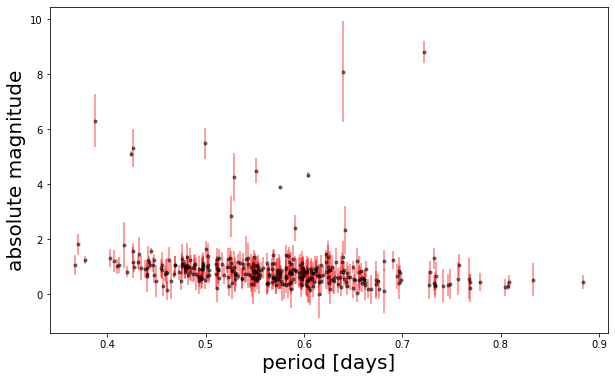

In [90]:
dr2_M = dr2_quality_cuts_table["dr2_mag"] - 5*np.log10(dr2_quality_cuts_table["r_est"]/10)
dr2_M_err = np.sqrt(dr2_quality_cuts_table["phot_g_mean_flux_over_error"]**-2 + (5*(dr2_quality_cuts_table["r_hi"] - dr2_quality_cuts_table["r_lo"])/(2*dr2_quality_cuts_table["r_est"]))**2)
dr2_pf_err = dr2_quality_cuts_table["rr_pf_error"]


plt.figure(figsize=(10,6))
plt.errorbar(dr2_quality_cuts_table["rr_pf"], dr2_M, yerr=dr2_M_err, xerr=dr2_pf_err,
             fmt=".k", alpha=0.5, ecolor="red")
plt.xlabel("period [days]", fontsize=20)
plt.ylabel("absolute magnitude", fontsize=20)

Throwing out the final outliers gives us the following plot:

Text(0, 0.5, 'absolute magnitude')

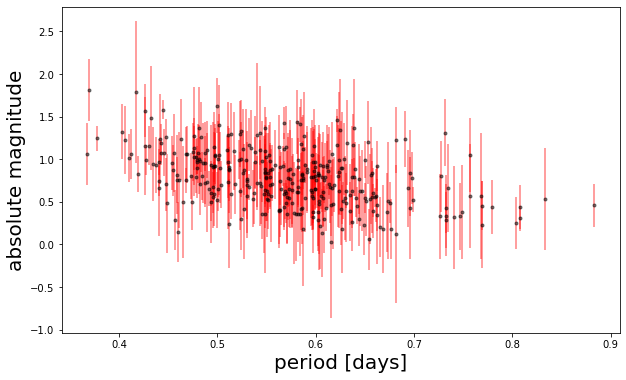

In [91]:
dr2_M = dr2_quality_cuts_table["dr2_mag"] - 5*np.log10(dr2_quality_cuts_table["r_est"]/10)
dr2_M_err = np.sqrt(dr2_quality_cuts_table["phot_g_mean_flux_over_error"]**-2 + (5*(dr2_quality_cuts_table["r_hi"] - dr2_quality_cuts_table["r_lo"])/(2*dr2_quality_cuts_table["r_est"]))**2)
dr2_pf_err = dr2_quality_cuts_table["rr_pf_error"]

cut_index = magnitude_cut(dr2_M)

plt.figure(figsize=(10,6))
plt.errorbar(dr2_quality_cuts_table["rr_pf"][cut_index], dr2_M[cut_index], 
             yerr=dr2_M_err[cut_index], xerr=dr2_pf_err[cut_index], fmt=".k", alpha=0.5, ecolor="red")
plt.xlabel("period [days]", fontsize=20)
plt.ylabel("absolute magnitude", fontsize=20)

# 1.19

In [92]:
quality_cuts_table[:5]
M = quality_cuts_table["g"] - 5*np.log10(quality_cuts_table["r_med_geo"]/10)
keep_index = magnitude_cut(M)
quality_cut_table = quality_cuts_table[keep_index]
quality_cut_table[:5]

dr3_id,dr2_id,r_med_geo,r_hi_geo,r_lo_geo,dr3_ra,dr3_dec,dr3_parallax,dr3_parallax_error,dr2_parallax,dr2_parallax_error,g,pf,pf_error,u,bp_rp,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux
,,pc,pc,pc,deg,deg,mas,mas,mas,mas,mag,d,d,,mag,mag,mag,mag,electron / s,electron / s,electron / s,,,,electron / s,electron / s,electron / s
int64,int64,float32,float32,float32,float64,float64,float64,float32,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float32,float32,float32,float64,float64,float64
4685757887726594816,4685757887726594816,2833.865,2955.3726,2740.6484,11.233266580284809,-73.88076610780682,0.3309123727206872,0.012480282,0.31373396498611444,0.02225346497165527,12.586509,0.7328986984075784,2.210916947336303e-07,1.3345154202959506,0.689024,12.557787,12.839874,12.15085,1157.9326738966517,2657.4567143960307,1862.4550022327373,150.33473,38.031136,59.47607,174077.49459461196,101066.09875599104,110771.50285217099
4793950312913699328,4793950312913699328,2563.536,2644.5483,2491.1633,84.96203078396498,-49.42814117443551,0.3711630341537675,0.013272379,0.2809782888456447,0.017400227901490622,12.946365,0.6102558420766953,2.0550550272740676e-07,1.285616795310239,0.6847296,12.900876,13.207869,12.523139,913.2832800996628,1901.7481394918973,1241.5665541058086,136.8342,37.86646,63.320206,124968.38131035703,72012.46480895128,78616.2485813695
6275283468151655424,6275283468151655424,3025.0488,3207.802,2883.0452,210.71536409582114,-24.071768493399738,0.2889588235635974,0.017614072,0.27733097268923157,0.028567784963639212,13.774176,0.46293095826261343,2.0152837216130544e-07,0.9671694214490262,0.6809864,13.775085,14.038564,13.357577,681.5164722533377,1449.328931126198,1094.0977927658919,85.54599,23.118666,33.318165,58301.00141615385,33506.55198699923,36453.32959484706
6321036891467501952,6321036891467501952,2104.1118,2186.5425,2006.1956,230.7006634391497,-8.366211767095717,0.45047662580026865,0.016339941,0.4631321386531367,0.037470624912400684,12.468434,0.6074482218867095,3.295367417031305e-07,1.261503502404321,0.70791435,12.453366,12.740816,12.032902,2080.121268355226,4577.038728781631,2865.869920130196,93.3005,24.190456,43.087467,194076.35740194676,110720.65284767127,123483.07148699572
6327036861995922560,6327036861995922560,3035.6802,3207.5933,2857.4646,222.5886563367257,-9.097310102960652,0.2916119349556604,0.018847315,0.32170454751901223,0.028733566255264246,13.028171,0.6438927625868223,5.984427221020134e-07,1.2616067242531754,0.7098627,13.007423,13.2919445,12.582082,1470.7576582634504,3127.647706305267,1956.1655215343676,78.80196,21.308834,38.065346,115898.58635973785,66646.52480302226,74462.11455381016


In [93]:
M = quality_cut_table["g"] - 5*np.log10(quality_cut_table["r_med_geo"]/10)
M_err = 5*np.log10(quality_cut_table["r_lo_geo"]/10) - 5*np.log10(quality_cut_table["r_hi_geo"]/10)
period = quality_cut_table["pf"]

M = np.asarray(M)
M_err = np.asarray(M_err)
period = np.asarray(period)

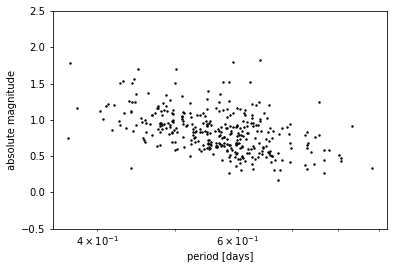

In [94]:
plt.figure()
plt.scatter(period, M, s=2, color="black")
plt.ylim(-0.5, 2.5)
plt.xlabel("period [days]")
plt.ylabel("absolute magnitude")
plt.xscale("log")

## i )

In [95]:
from tqdm import tqdm, trange

In [96]:
def mh_mcmc(x0, ln_prob_fn, prop_fn, ln_prob_fn_kwargs={}, prop_fn_kwargs={}, iterations=10000, burn_fraction=0):
    dimensions = len(x0)
    burn = int(burn_fraction*iterations)
    
    chain = np.zeros((iterations, dimensions))
    lnprob = np.zeros(iterations)
    acceptance_rate = np.zeros(iterations)
    
    chain[0] = x0
    lnprob0 = ln_prob_fn(x0, **ln_prob_fn_kwargs)
    lnprob[0] = lnprob0
    
    n_accept = 0
    for i in trange(1, iterations):
        x_new = prop_fn(x0, **prop_fn_kwargs)
        u = np.random.uniform(0, 1)
        
        ln_prob_new = ln_prob_fn(x_new, **ln_prob_fn_kwargs)
        
        prob_accept = min(1, np.exp(ln_prob_new - lnprob0))
        
        if u < prob_accept:
            x0 = x_new
            lnprob0 = ln_prob_new
            n_accept += 1
            
        chain[i] = x0
        lnprob[i] = lnprob0
        acceptance_rate[i] = n_accept / i
    
    return chain[burn:], acceptance_rate[burn:], lnprob[burn:]

In [97]:
def symmetric_proposal(x, stepsize=np.asarray([1])):
    x_new = np.random.uniform(low = x-0.5*stepsize,
                              high= x+0.5*stepsize, 
                              size= x.shape)
    return x_new

In [98]:
def gaussian_ln_posterior(x):
    mu = 1
    std = 0.1
    
    return -0.5 * (x - mu)**2/std**2

In [99]:
stepsize = 0.59

x0 = np.random.randn(1)
chain, acceptance_rate, ln_prob = mh_mcmc(x0, gaussian_ln_posterior,
                                          symmetric_proposal,
                                          prop_fn_kwargs={"stepsize":stepsize},
                                          burn_fraction=0.2)

100%|██████████| 9999/9999 [00:00<00:00, 10976.89it/s]


In [100]:
def gaussian_plot(x, sigma, mu):
    return 1/np.sqrt(2*np.pi*sigma**2) * np.exp(-0.5*(mu - x)**2 / sigma**2)

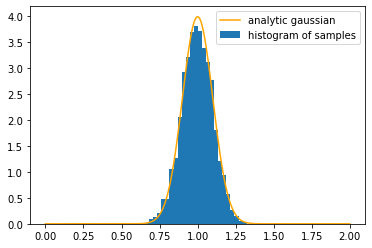

In [101]:
plt.figure()
x = np.linspace(0, 2, num=1000)
p = gaussian_plot(x, 0.1, 1)
_ = plt.hist(chain[::,0], bins=30, density=True, label="histogram of samples")
plt.plot(x, p, color="orange", label="analytic gaussian")
plt.legend()
plt.show()

Text(0, 0.5, 'estimate of $\\mu$')

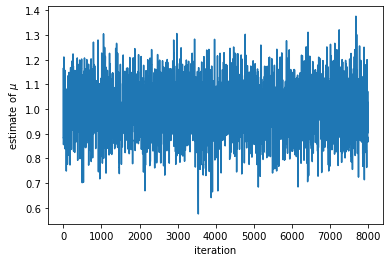

In [102]:
plt.figure()
plt.plot(range(len(chain)), chain[::, 0])
plt.xlabel("iteration")
plt.ylabel(r"estimate of $\mu$")

Text(0, 0.5, 'ln (posterior)')

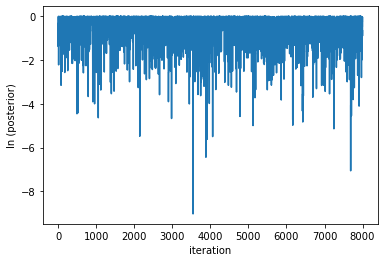

In [103]:
plt.figure()
plt.plot(range(len(chain)), ln_prob)
plt.xlabel("iteration")
plt.ylabel("ln (posterior)")

In [104]:
def ln_likelihood_data(x, M_G, P, sigma_i):
    """calculates the log likelihood (posterior) of a set of fitting
    parameters (a, b, sigma) given a set of data points (M_G, P).
    Calculates the likelihood of for each datapoint on the given 
    parameters and sums over all points to get the total likelihood.
    
    Parameters to fit the equation M_G = a*ln(P) + b
    
    M_G: array of the brightness (in magnitudes) of the datapoits 
    
    P: array of the periods (in days) corresponding to the matnitudes
    
    sigma_i: array of the errors in the data
    
    x: array of all parameters we are testing on 
    
    x[0]: float estimate of the fit parameter corresponding to `a`
    
    x[1]: float estimate of the fit parameter corresponding to `b`
    
    x[2]: float estimate of the scatter of the data points"""
    
    sigma = np.sqrt(x[2]**2 + sigma_i**2)

    return np.sum(-0.5*np.log(2*np.pi*sigma**2) - 0.5*((M_G - x[0]*np.log10(P) - x[1])**2 / sigma**2))

In [105]:
a_step = 0.11#0.05#0.08#0.101
b_step = 0.11#0.05#0.08#0.101
sigma_step = 0.05

stepsize = np.asarray([a_step, b_step, sigma_step])

a_prior = np.random.uniform(-5,5)
b_prior = np.random.uniform(-5,5)
sigma_prior = np.random.uniform(0, 5)

x0 = np.asarray([a_prior, b_prior, sigma_prior])
    
chain, acceptance_rate, ln_prob = mh_mcmc(x0, ln_likelihood_data,
                                          symmetric_proposal,
                                          ln_prob_fn_kwargs={"M_G": M,"P":period, "sigma_i":M_err},
                                          prop_fn_kwargs={"stepsize":stepsize},
                                          burn_fraction=0.2, iterations=10000)

100%|██████████| 9999/9999 [00:02<00:00, 4712.95it/s]


In [106]:
chain_a = chain[::, 0]
chain_b = chain[::, 1]
chain_sigma = chain[::, 2]

Now we will look at the convergances of the three variables we were fitting on, as well as the acceptance rate and log of the posterior

Text(0.5, 0, 'iteration')

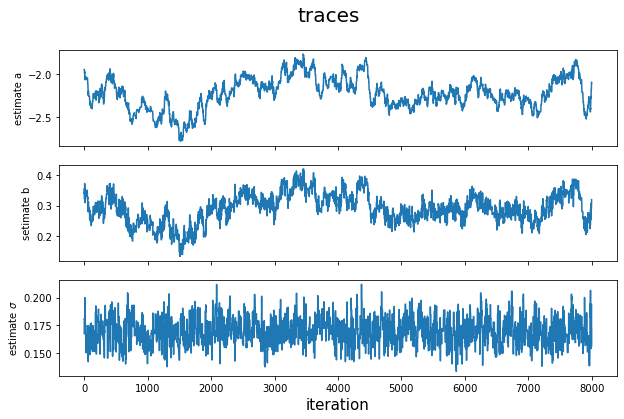

In [107]:
x = np.arange(len(chain))
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,6), sharex=True)
plt.suptitle("traces", fontsize=20)
ax1.plot(x, chain_a)
ax1.set_ylabel("estimate a")
ax2.plot(x, chain_b)
ax2.set_ylabel("setimate b")
ax3.plot(x, chain_sigma)
ax3.set_ylabel(r"estimate $\sigma$")
plt.xlabel("iteration", fontsize=15)

Text(0.5, 0, 'iteration')

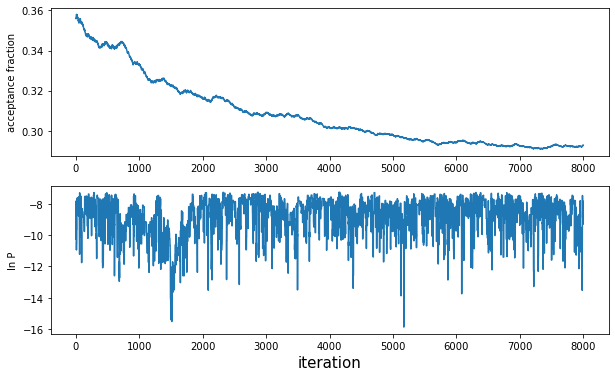

In [108]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6))
ax1.plot(x, acceptance_rate)
ax1.set_ylabel("acceptance fraction")
ax2.plot(x, ln_prob)
ax2.set_ylabel("ln P")
plt.xlabel("iteration", fontsize=15)

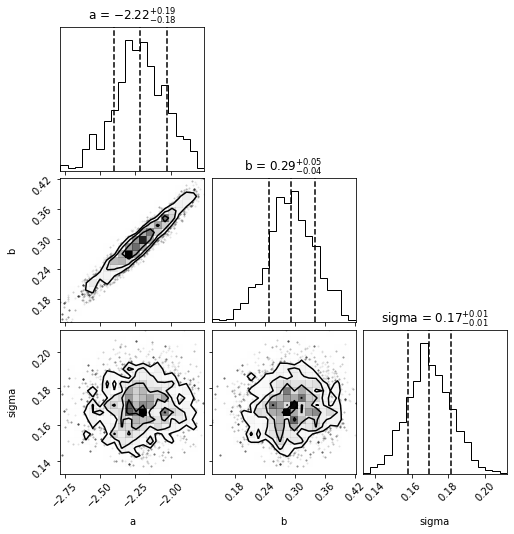

In [109]:
fig = corner.corner(chain, quantiles=(0.16, 0.5, 0.84), labels=["a", "b", "sigma"], show_titles=True)

In [110]:
a = []
b = []
for i in range(len(chain)):
    if i%160==0:
        one_a = chain_a[i]
        one_b = chain_b[i]
        a.append(one_a)
        b.append(one_b)
        
parameters = pd.DataFrame(data={"a":a, "b":b})

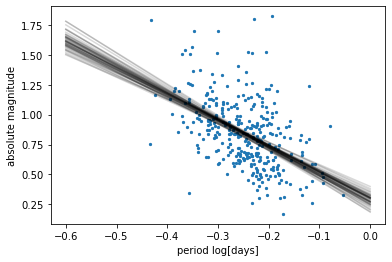

In [111]:
plt.figure()
plt.scatter(np.log10(period), M, s=5, label="gaia")
plt.xlabel("period log[days]")
plt.ylabel("absolute magnitude")
x = np.linspace(-0.6,0, num=1000)
for i in range(len(parameters)):
    one_fit = parameters.iloc[i]
    one_line = one_fit["a"]*x + one_fit["b"]
    plt.plot(x, one_line, c="black", alpha=0.15)

Taking fifty random sets on paramaters for a line and plotting them gives us the following plot. All the lines pass through the center of the cluster, which indicates that al of them could be values that describe the relation between the period and absolute magnitude. 

## ii)

In [112]:
import pymc3 as pm
import arviz as az
from arviz import plot_trace as traceplot

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 75 seconds.


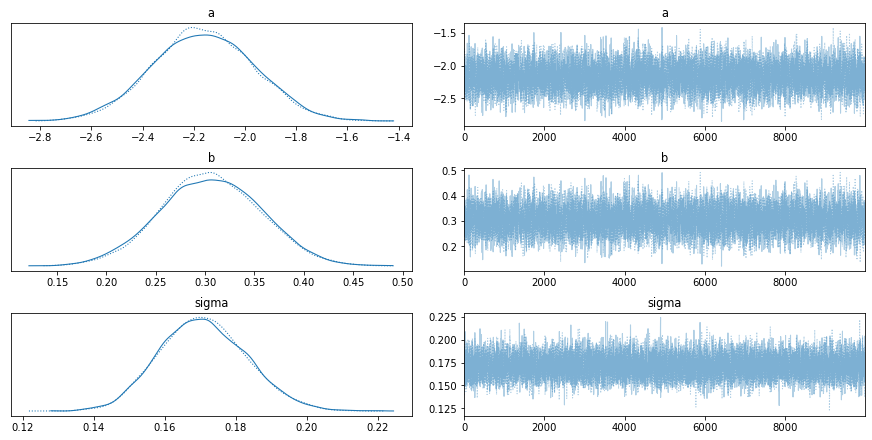

In [113]:
with pm.Model() as model:
    a = pm.Normal("a", mu=0, sd=5)
    b = pm.Normal("b", mu=0, sd=5)
    
    sigma = pm.HalfNormal("sigma", sd=5)
    
    def ln_likelihood(per, mag, sigma_i):
        total_sigma = np.sqrt(sigma**2 + sigma_i**2)
        return (-0.5*np.log(2*np.pi*total_sigma**2) - (mag - a*np.log10(per) - b)**2 / (2*total_sigma**2)).sum()
    
    likelihood = pm.Potential("ln_likelihood", ln_likelihood(period, M, M_err))
    
    #log_likelihood = pm.Normal.dist(mu=a*np.log(period) + b, sd=sigma).logp(M)
    
    #pm.Potential("M_G", log_likelihood)
    
    trace_ii = pm.sample(draws=10000, tune=1000, chains=2,
                     cores=2, discard_tuned_samples=True,
                     return_inferencedata=False)
    
    _ = pm.traceplot(trace_ii, var_names=["a", "b", "sigma"])
    
    pm.summary(trace_ii, var_names=["a", "b", "sigma"])

In [114]:
summ = pm.summary(trace_ii, var_names=["a", "b", "sigma"])
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-2.163,0.199,-2.529,-1.783,0.002,0.002,7149.0,7149.0,7154.0,7936.0,1.0
b,0.306,0.051,0.208,0.401,0.001,0.000,7230.0,7198.0,7225.0,7964.0,1.0
sigma,0.171,0.012,0.148,0.193,0.000,0.000,9021.0,8990.0,9030.0,9116.0,1.0


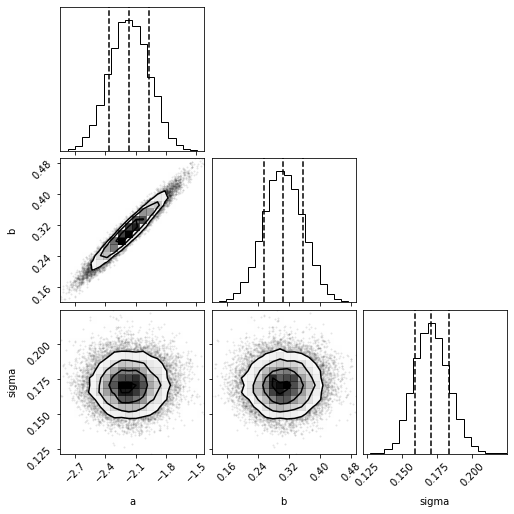

In [115]:
samples = pm.trace_to_dataframe(trace_ii, varnames=["a", "b", "sigma"])
_ = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], show_title=True)

Text(0, 0.5, 'absolute magnitude')

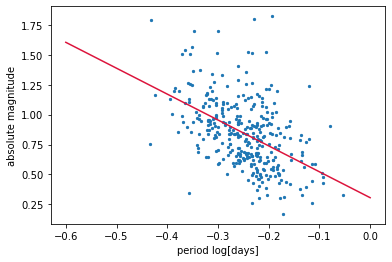

In [116]:
a = summ["mean"][0]
b = summ["mean"][1]
x = np.linspace(-0.6,0, num=1000)
line = a*x + b

plt.figure()
plt.scatter(np.log10(period), M, s=5, label="gaia")
plt.plot(x, line, color="crimson")
#plt.plot(x, line, color="red")
plt.xlabel("period log[days]")
plt.ylabel("absolute magnitude")

## iii)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 80 seconds.
The acceptance probability does not match the target. It is 0.908056759228137, but should be close to 0.8. Try to increase the number of tuning steps.


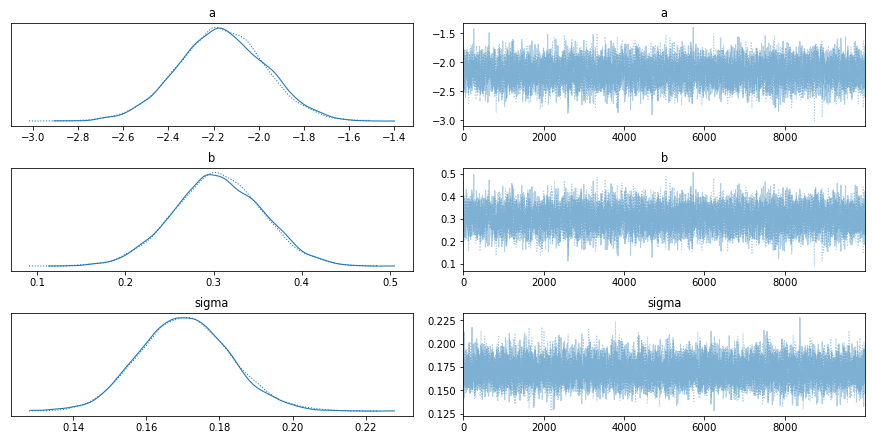

In [117]:
with pm.Model() as model:
    a = pm.Normal("a", mu=0, sd=5)
    b = pm.Normal("b", mu=0, sd=5)
    sigma = pm.HalfNormal("sigma", sd=5)
    
    pm.Normal("obs", mu=a*np.log10(period) + b, observed=M, sd=np.sqrt(sigma**2 + M_err**2))
    
    trace_iii = pm.sample(draws=10000, tune=1000, chains=2,
                     cores=2, discard_tuned_samples=True,
                     return_inferencedata=False)
    
    _ = pm.traceplot(trace_iii, var_names=["a", "b", "sigma"])
    
    pm.summary(trace_iii, var_names=["a", "b", "sigma"])

In [118]:
summ_19 = pm.summary(trace_iii, var_names=["a", "b", "sigma"])
summ_19

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-2.167,0.195,-2.539,-1.803,0.002,0.002,7852.0,7832.0,7858.0,7995.0,1.0
b,0.305,0.050,0.209,0.398,0.001,0.000,7820.0,7799.0,7824.0,7732.0,1.0
sigma,0.171,0.012,0.148,0.194,0.000,0.000,10092.0,10092.0,10081.0,8675.0,1.0


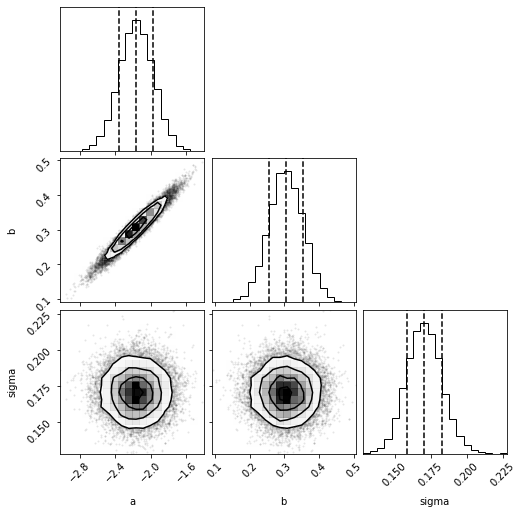

In [119]:
samples = pm.trace_to_dataframe(trace_iii, varnames=["a", "b", "sigma"])
_ = corner.corner(samples, labels=["a", "b", "sigma"],
                  quantiles=[0.16, 0.5, 0.84], show_title=True, title_kwargs={"fontsize":12})

Plotting the traces of all three samplings on one corner plot:

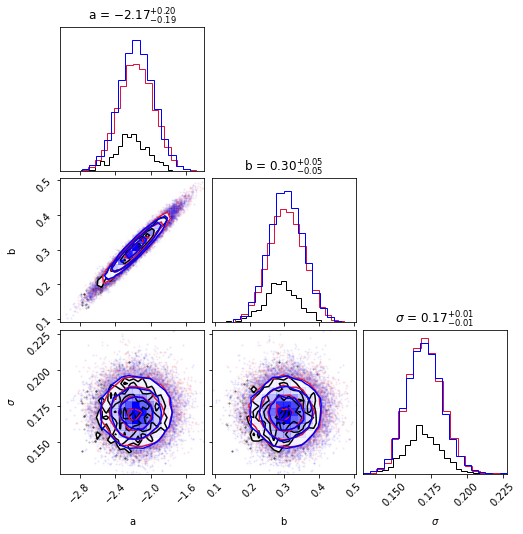

In [120]:
fig = corner.corner(chain, labels=["a", "b", r"$\sigma$"],
                     show_titles=True, color="black", title_kwargs={"fontsize":12},
                     alpha=0.3)

plot_trace_ii = np.vstack([trace_ii['a'],trace_ii['b'],trace_ii['sigma']])

fig = corner.corner(np.transpose(plot_trace_ii), labels=["a", "b", r"$\sigma$"],
                     show_titles=True, color="crimson", title_kwargs={"fontsize":12},
                     alpha=0.3, fig=fig)

plot_trace_iii = np.vstack([trace_iii['a'],trace_iii['b'],trace_iii['sigma']])

fig = corner.corner(np.transpose(plot_trace_iii), labels=["a", "b", r"$\sigma$"],
                     show_titles=True, color="blue", title_kwargs={"fontsize":12},
                     alpha=0.3, fig=fig)
plt.show()

When comparing all three corner plots, we can see that the estimates for `a` and `b` all agree, but when looking at the estimates for `sigma` we can see that only the plot for the third sampling shows up. I attribute this to including $\sigma_i^2$ from the errors in the data for only the third sampling. I suspect that the addition of some scatter reduced the "weight" on the intrinsic scatter being estimated by the MCMC sampler. 

# 1.20 

In [121]:
wise_query = """SELECT * 
FROM gaiadr2.allwise_best_neighbour as wise_neigh
JOIN gaiadr1.allwise_original_valid as wise_og on wise_og.allwise_oid = wise_neigh.allwise_oid 
JOIN gaiaedr3.dr2_neighbourhood as neigh on wise_neigh.source_id = neigh.dr2_source_id
JOIN gaiaedr3.gaia_source as edr3 on edr3.source_id = neigh.dr3_source_id
JOIN gaiadr2.vari_rrlyrae as rr on rr.source_id = neigh.dr2_source_id
WHERE edr3.parallax>0.25
AND edr3.parallax_over_error>5
AND abs(edr3.b)>30
AND rr.pf IS NOT NULL"""

wise_table = get_gaia_query(wise_query)
original_len = len(wise_table)
print(original_len)

464


In [122]:
wise_table[:5]

source_id,original_ext_source_id,angular_distance,gaia_astrometric_params,allwise_oid,number_of_neighbours,number_of_mates,best_neighbour_multiplicity,allwise_oid_2,designation,ra,dec,ra_error,dec_error,radec_co_error,w1mpro,w1mpro_error,w2mpro,w2mpro_error,w3mpro,w3mpro_error,w4mpro,w4mpro_error,cc_flags,ext_flag,var_flag,ph_qual,w1mjd_mean,w2mjd_mean,w3mjd_mean,w4mjd_mean,w1gmag,w1gmag_error,w2gmag,w2gmag_error,w3gmag,w3gmag_error,w4gmag,w4gmag_error,tmass_key,dr2_source_id,dr3_source_id,angular_distance_2,magnitude_difference,proper_motion_propagation,solution_id,designation_2,source_id_2,random_index,ref_epoch,ra_2,ra_error_2,dec_2,dec_error_2,parallax,parallax_error,parallax_over_error,pm,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,nu_eff_used_in_astrometry,pseudocolour,pseudocolour_error,ra_pseudocolour_corr,dec_pseudocolour_corr,parallax_pseudocolour_corr,pmra_pseudocolour_corr,pmdec_pseudocolour_corr,astrometric_matched_transits,visibility_periods_used,astrometric_sigma5d_max,matched_transits,new_matched_transits,matched_transits_removed,ipd_gof_harmonic_amplitude,ipd_gof_harmonic_phase,ipd_frac_multi_peak,ipd_frac_odd_win,ruwe,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_n_contaminated_transits,phot_bp_n_blended_transits,phot_rp_n_contaminated_transits,phot_rp_n_blended_transits,phot_proc_mode,phot_bp_rp_excess_factor,bp_rp,bp_g,g_rp,dr2_radial_velocity,dr2_radial_velocity_error,dr2_rv_nb_transits,dr2_rv_template_teff,dr2_rv_template_logg,dr2_rv_template_fe_h,l,b,ecl_lon,ecl_lat,solution_id_2,source_id_3,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification
,,arcsec,,,,,,,,deg,deg,arcsec,arcsec,arcsec,mag,mag,mag,mag,mag,mag,mag,mag,,,,,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,,,,mas,mag,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / um,1 / um,1 / um,,,,,,,,mas,,,,,deg,,,,,,,,deg,deg,deg,deg,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,,,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,deg,deg,deg,deg,,,d,d,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,dex,dex,,,,,rad,rad,rad,rad,,,,mag,mag,
int64,object,float64,int16,int64,int32,int16,int16,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,int16,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float32,float32,bool,int64,object,int64,int64,float64,float64,float32,float64,float32,float64,float32,float32,float32,float64,float32,fl

# 1.21

In [123]:
wise_pf = np.asarray(wise_table["pf"])
wise_pf_error = np.asarray(wise_table["pf_error"])
wise_mag = np.asarray(wise_table["w2mpro"])
wise_mag_error = np.asarray(wise_table["w2mpro_error"])
wise_parallax = np.asarray(wise_table["parallax"])
wise_parallax_error = np.asarray(wise_table["parallax_error"])

To compute the absolut magnitude, we shall use the following formula: 

$M = m + 5 + 5log_{10}(\varpi/1000)$ where $\varpi$ is the parallax in milliarcseconds ([Babusiaux et al, 2018](https://arxiv.org/abs/1804.09378)), $M$ is the absolute magnitude and $m$ is the apparent magnitude

To calculate the error in the absolute magnitude we will find the change in absolute magnitude with respect to changes in the apparent magnitude and parallax. Taking the derivative of absolute magnitude with respect to parallax gives: $dM = \cfrac{5}{ln(10)} \cfrac{d\varpi}{\varpi}$, and taking the derivative of absolute magnitude with respect to the apparent magnitude gives: $dM = dm$. Combining these gives us $\Delta M = \sqrt{(\Delta m)^2 + (\cfrac{5}{ln(10)} \cfrac{\Delta \varpi}{\varpi})^2}$, for small changes in $m$ and $\varpi$

In [124]:
abs_mag = wise_mag + 5 + 5*np.log10(wise_parallax/1000)
abs_mag_err = np.sqrt((wise_mag_error)**2 + (5/np.log(10) * wise_parallax_error/wise_parallax)**2)

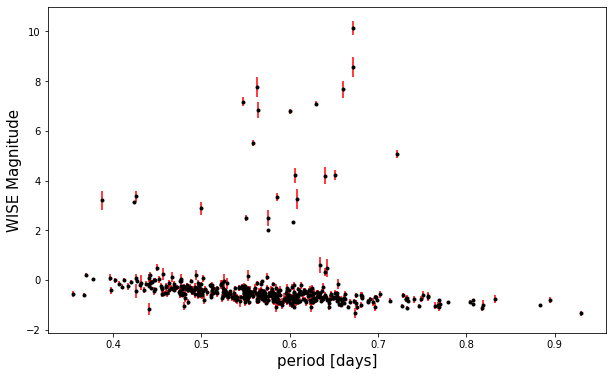

In [125]:
plt.figure(figsize=(10,6))
plt.errorbar(wise_pf, abs_mag, yerr=abs_mag_err,
             xerr=wise_pf_error,
             fmt=".k", ecolor="red")
plt.xlabel("period [days]", fontsize=15)
plt.ylabel("WISE Magnitude", fontsize=15)
plt.show()

This data has some outliers, which I will remove via sigma clipping. 

In [126]:
def sigma_clip(arr, N):
    std = np.std(arr)
    mean = np.average(arr)
    keep_indices = np.where((arr > mean-N*std) & (arr < mean+N*std))
    return keep_indices[0]

In [127]:
keep = sigma_clip(abs_mag, 1.65)
reduced_wise_table = wise_table[keep]
print("Sigma clipping removed %s sources"% (original_len - len(reduced_wise_table)))

Sigma clipping removed 23 sources


In [128]:
wise_pf = np.asarray(reduced_wise_table["pf"])
wise_pf_error = np.asarray(reduced_wise_table["pf_error"])
wise_mag = np.asarray(reduced_wise_table["w2mpro"])
wise_mag_error = np.asarray(reduced_wise_table["w2mpro_error"])
wise_parallax = np.asarray(reduced_wise_table["parallax"])
wise_parallax_error = np.asarray(reduced_wise_table["parallax_error"])

In [129]:
abs_mag = wise_mag + 5 + 5*np.log10(wise_parallax/1000)
abs_mag_err = wise_mag_error + 5/np.log(10) * wise_parallax_error/wise_parallax

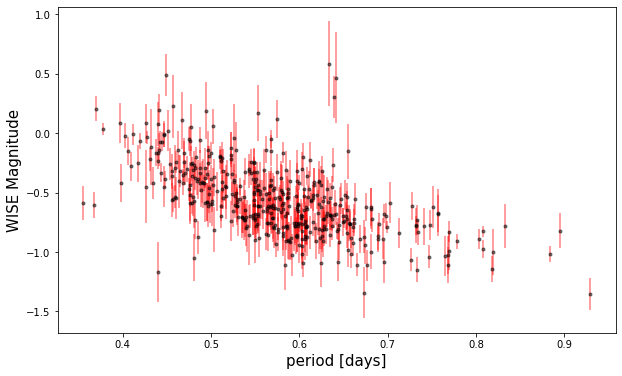

In [130]:
plt.figure(figsize=(10,6))
plt.errorbar(wise_pf, abs_mag, yerr=abs_mag_err,
             xerr=wise_pf_error,
             fmt=".k", ecolor="red", alpha=0.5)
plt.xlabel("period [days]", fontsize=15)
plt.ylabel("WISE Magnitude", fontsize=15)
plt.show()

In [131]:
period = np.asarray(wise_pf)
M = np.asarray(abs_mag)
M_err = np.asarray(abs_mag_err)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 97 seconds.


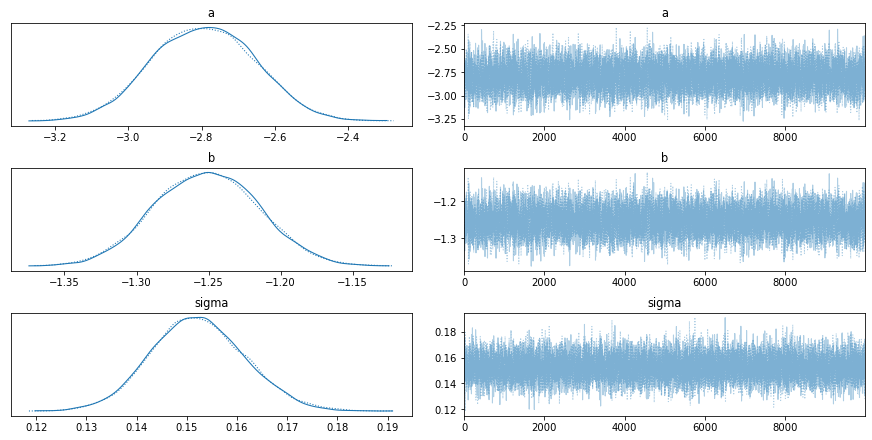

In [132]:
with pm.Model() as model:
    a = pm.Normal("a", mu=0, sd=5)
    b = pm.Normal("b", mu=0, sd=5)
    sigma = pm.HalfNormal("sigma", sd=5)
    
    pm.Normal("obs", mu=a*np.log10(period) + b, observed=M, sd=np.sqrt(sigma**2 + M_err**2))
    
    trace_20 = pm.sample(draws=10000, tune=1000, chains=2,
                     cores=2, discard_tuned_samples=True,
                     return_inferencedata=False)
    
    _ = pm.traceplot(trace_20, var_names=["a", "b", "sigma"])
    
    pm.summary(trace_20, var_names=["a", "b", "sigma"])

In [133]:
summ_21 = pm.summary(trace_20, var_names=["a", "b", "sigma"])
summ_21

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-2.794,0.141,-3.056,-2.532,0.002,0.001,8004.0,8004.0,7991.0,8592.0,1.0
b,-1.251,0.036,-1.318,-1.184,0.000,0.000,7963.0,7963.0,7950.0,8463.0,1.0
sigma,0.152,0.009,0.135,0.170,0.000,0.000,10156.0,10156.0,10127.0,8575.0,1.0


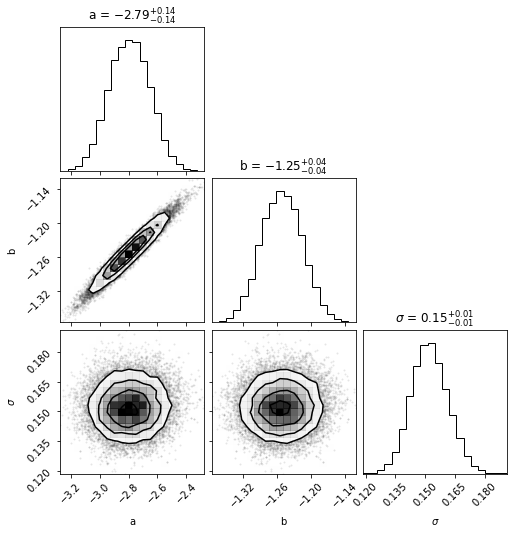

In [134]:
plot_trace_20 = np.vstack([trace_20['a'],trace_20['b'],trace_20['sigma']])

fig = corner.corner(np.transpose(plot_trace_20), labels=["a", "b", r"$\sigma$"],
                     show_titles=True, title_kwargs={"fontsize":12},
                     alpha=0.3)
plt.show()

# 1.22

In [135]:
W2_slope = summ_21["mean"][0]
G_slope = summ_19["mean"][0]
print("The slope of the period-luminosity relationship in the optical band is %s "%G_slope)
print("and the slope of the relationship at the near-infrared band is %s"%(W2_slope))

if abs(W2_slope) > abs(G_slope):
    print("The slope at the near infrared band is steeper")
else:
    print("The slope at the near optical band is steeper")
    

The slope of the period-luminosity relationship in the optical band is -2.167 
and the slope of the relationship at the near-infrared band is -2.794
The slope at the near infrared band is steeper


# 1.23

According to Table 2 from [Klein and Bloom 2014](https://arxiv.org/pdf/1404.4870.pdf) the V-band slope was $−0.4091 \pm 0.2370$ while my slope for the G-band was -2.16, and their W2 band slope was $−2.2337 \pm 0.1249$ while mine was -2.79, which agrees much more closely. The Klein and Bloom period-magnitude relationship is defined as $m_{ij} = \mu_i + M_{0,j} + \alpha_j log_{10}(P_i/P_0) + E(B-V)_i(a_j R_V + b_j) + \epsilon_{ij}$, which is notably more detailed than the simple $M_i = a log_{10}(P_i[days]) + b$ that I used. Their model also accounts for the extinction and color excess factor, which I did not include in mine. The effect of extinction on light at higher wavelength is more pronounced than at lower wavelengths, so the larger difference in the slope at G (optical) could be attributed to this. The longer wavelength near-infrared light is less sensitive to scattering due to dust and gas along the line of sight. 

# 1.24 

In [136]:
quality_cut_table[:5]

dr3_id,dr2_id,r_med_geo,r_hi_geo,r_lo_geo,dr3_ra,dr3_dec,dr3_parallax,dr3_parallax_error,dr2_parallax,dr2_parallax_error,g,pf,pf_error,u,bp_rp,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux_error,phot_bp_mean_flux_error,phot_rp_mean_flux_error,phot_g_mean_flux_over_error,phot_bp_mean_flux_over_error,phot_rp_mean_flux_over_error,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux
,,pc,pc,pc,deg,deg,mas,mas,mas,mas,mag,d,d,,mag,mag,mag,mag,electron / s,electron / s,electron / s,,,,electron / s,electron / s,electron / s
int64,int64,float32,float32,float32,float64,float64,float64,float32,float64,float64,float32,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float32,float32,float32,float64,float64,float64
4685757887726594816,4685757887726594816,2833.865,2955.3726,2740.6484,11.233266580284809,-73.88076610780682,0.3309123727206872,0.012480282,0.31373396498611444,0.02225346497165527,12.586509,0.7328986984075784,2.210916947336303e-07,1.3345154202959506,0.689024,12.557787,12.839874,12.15085,1157.9326738966517,2657.4567143960307,1862.4550022327373,150.33473,38.031136,59.47607,174077.49459461196,101066.09875599104,110771.50285217099
4793950312913699328,4793950312913699328,2563.536,2644.5483,2491.1633,84.96203078396498,-49.42814117443551,0.3711630341537675,0.013272379,0.2809782888456447,0.017400227901490622,12.946365,0.6102558420766953,2.0550550272740676e-07,1.285616795310239,0.6847296,12.900876,13.207869,12.523139,913.2832800996628,1901.7481394918973,1241.5665541058086,136.8342,37.86646,63.320206,124968.38131035703,72012.46480895128,78616.2485813695
6275283468151655424,6275283468151655424,3025.0488,3207.802,2883.0452,210.71536409582114,-24.071768493399738,0.2889588235635974,0.017614072,0.27733097268923157,0.028567784963639212,13.774176,0.46293095826261343,2.0152837216130544e-07,0.9671694214490262,0.6809864,13.775085,14.038564,13.357577,681.5164722533377,1449.328931126198,1094.0977927658919,85.54599,23.118666,33.318165,58301.00141615385,33506.55198699923,36453.32959484706
6321036891467501952,6321036891467501952,2104.1118,2186.5425,2006.1956,230.7006634391497,-8.366211767095717,0.45047662580026865,0.016339941,0.4631321386531367,0.037470624912400684,12.468434,0.6074482218867095,3.295367417031305e-07,1.261503502404321,0.70791435,12.453366,12.740816,12.032902,2080.121268355226,4577.038728781631,2865.869920130196,93.3005,24.190456,43.087467,194076.35740194676,110720.65284767127,123483.07148699572
6327036861995922560,6327036861995922560,3035.6802,3207.5933,2857.4646,222.5886563367257,-9.097310102960652,0.2916119349556604,0.018847315,0.32170454751901223,0.028733566255264246,13.028171,0.6438927625868223,5.984427221020134e-07,1.2616067242531754,0.7098627,13.007423,13.2919445,12.582082,1470.7576582634504,3127.647706305267,1956.1655215343676,78.80196,21.308834,38.065346,115898.58635973785,66646.52480302226,74462.11455381016


In [137]:
pf = quality_cut_table["pf"]
pf_error = quality_cut_table["pf_error"]

bp_rp = quality_cut_table["bp_rp"]
bp_minus_rp = quality_cut_table["phot_bp_mean_mag"] - quality_cut_table["phot_rp_mean_mag"]

# calculating errors in fluxes
flux_bp = quality_cut_table["phot_bp_mean_flux"]
flux_rp = quality_cut_table["phot_rp_mean_flux"]
error_bp_flux = quality_cut_table["phot_bp_mean_flux_error"]
error_rp_flux = quality_cut_table["phot_rp_mean_flux_error"]

# error in magnitudes
mag_bp_error = 1.09/quality_cut_table["phot_bp_mean_flux_over_error"]
mag_rp_error = 1.09/quality_cut_table["phot_rp_mean_flux_over_error"]

bp_rp_error = np.sqrt(mag_bp_error**2 + mag_rp_error**2)

Text(0, 0.5, '$G_{BP} - G_{RP}$')

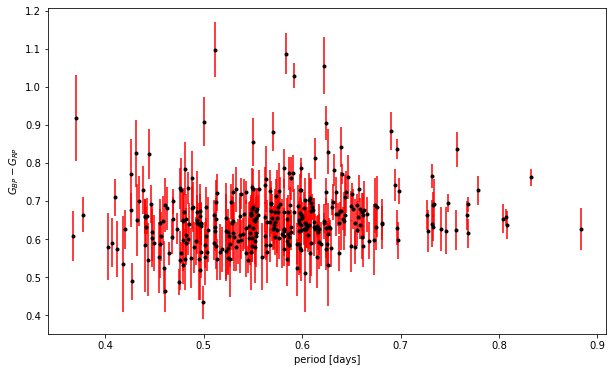

In [138]:
plt.figure(figsize=(10,6))
plt.errorbar(pf, bp_rp, xerr=pf_error, yerr=bp_rp_error,
             ecolor="red", fmt=".k")
plt.xlabel("period [days]")
plt.ylabel(r"$G_{BP} - G_{RP}$")

In [139]:
model = pm.Model()
with model:
    #establish priors:
    b = pm.Normal("b", mu =0, sd =10)
    a = pm.Normal("a", mu =0, sd =10)
    sigma_scattered = pm.HalfNormal("sigma_scattered",sd =5 )
    Mag_G = pm.Normal("Mag_G", mu = a*np.log10(pf)+b,
                      sigma = np.sqrt(sigma_scattered**2+bp_rp_error**2), 
                      observed = bp_rp)
    trace= pm.sample(draws=2500, tune=400, chains=2,
                     cores=2, discard_tuned_samples=True,
                     return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_scattered, a, b]


Sampling 2 chains for 400 tune and 2_500 draw iterations (800 + 5_000 draws total) took 54 seconds.
The acceptance probability does not match the target. It is 0.914649422337058, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8999987710609308, but should be close to 0.8. Try to increase the number of tuning steps.


In [140]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b,0.714,0.017,0.683,0.746,0.000,0.000,1568.0,1567.0,1569.0,1763.0,1.0
a,0.231,0.068,0.103,0.352,0.002,0.001,1570.0,1479.0,1569.0,1736.0,1.0
sigma_scattered,0.062,0.004,0.054,0.069,0.000,0.000,2425.0,2425.0,2412.0,2113.0,1.0


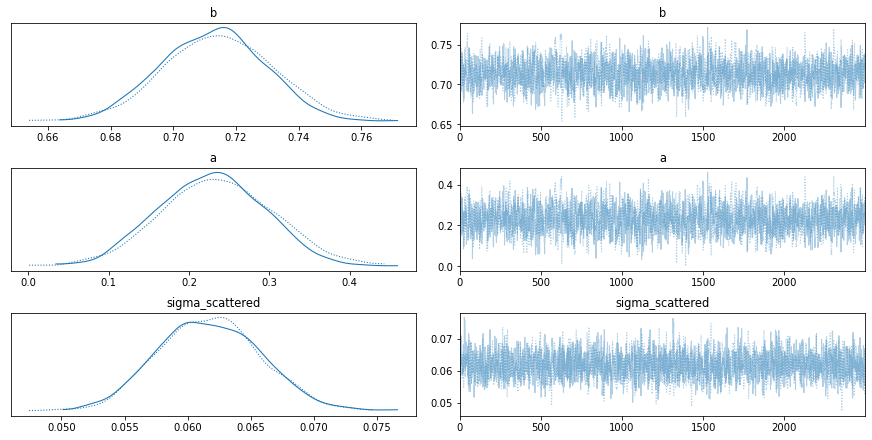

In [141]:
with model:
    traceplot(trace)

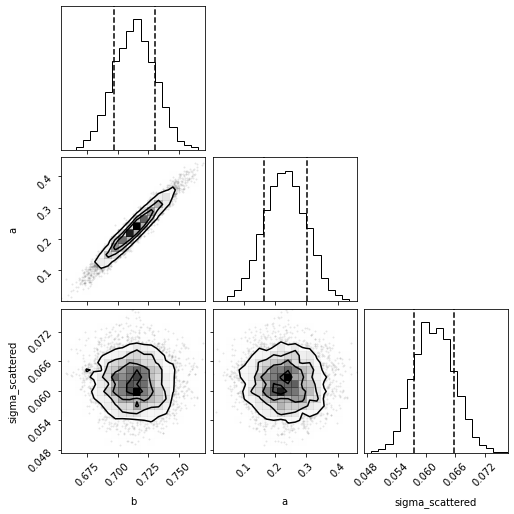

In [142]:
import corner 
samples = pm.backends.tracetab.trace_to_dataframe(trace)
_ = corner.corner(samples, quantiles=[0.16, 0.84])

In [143]:
a = az.summary(trace)["mean"][1]
b = az.summary(trace)["mean"][0]

In [144]:
x = np.linspace(0.35, 1, num=1000)
def bp_rp_intrinsic(x, a, b):
    return a*np.log10(x) + b

trial_fit = bp_rp_intrinsic(x, a, b)

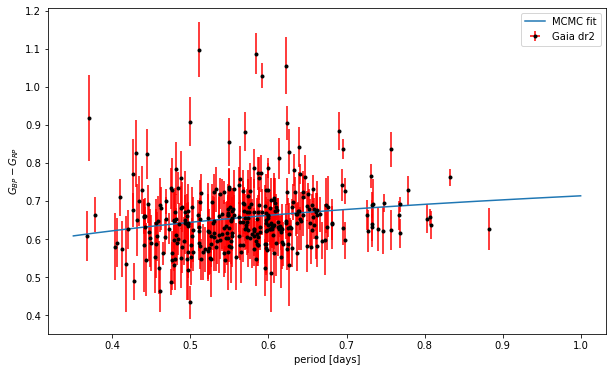

In [145]:
plt.figure(figsize=(10,6))
plt.errorbar(pf, bp_rp, xerr=pf_error, yerr=bp_rp_error,
             ecolor="red", fmt=".k", label="Gaia dr2")
plt.plot(x, trial_fit, label="MCMC fit")
plt.xlabel("period [days]")
plt.ylabel(r"$G_{BP} - G_{RP}$")
#plt.xscale("log")
plt.legend()
plt.show()

# 1.25

In [146]:
full_rr_lyrae_query = """SELECT * 
FROM gaiadr2.vari_rrlyrae as vari
INNER JOIN gaiadr2.gaia_source as gaia2 ON vari.source_id = gaia2.source_id
WHERE vari.pf IS NOT NULL
AND vari.g_absorption IS NOT NULL
AND phot_bp_mean_flux_over_error>10
AND phot_rp_mean_flux_over_error>10
"""

full_rr_lyrae_table = get_gaia_query(full_rr_lyrae_query)
len(full_rr_lyrae_table)

52752

In [147]:
full_rr_lyrae_table[:5]

solution_id,source_id,pf,pf_error,p1_o,p1_o_error,p2_o,p2_o_error,p3_o,p3_o_error,epoch_g,epoch_g_error,epoch_bp,epoch_bp_error,epoch_rp,epoch_rp_error,int_average_g,int_average_g_error,int_average_bp,int_average_bp_error,int_average_rp,int_average_rp_error,peak_to_peak_g,peak_to_peak_g_error,peak_to_peak_bp,peak_to_peak_bp_error,peak_to_peak_rp,peak_to_peak_rp_error,metallicity,metallicity_error,r21_g,r21_g_error,r31_g,r31_g_error,phi21_g,phi21_g_error,phi31_g,phi31_g_error,num_clean_epochs_g,num_clean_epochs_bp,num_clean_epochs_rp,g_absorption,g_absorption_error,best_classification,solution_id_2,designation,source_id_2,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,teff_val,teff_percentile_lower,teff_percentile_upper,a_g_val,a_g_percentile_lower,a_g_percentile_upper,e_bp_min_rp_val,e_bp_min_rp_percentile_lower,e_bp_min_rp_percentile_upper,flame_flags,radius_val,radius_percentile_lower,radius_percentile_upper,lum_val,lum_percentile_lower,lum_percentile_upper,datalink_url,epoch_photometry_url
,,d,d,d,d,d,d,d,d,d,d,d,d,d,d,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,dex,dex,,,,,rad,rad,rad,rad,,,,mag,mag,,,,,,yr,deg,mas,deg,mas,mas,mas,,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,,,,,,,mas,,,,1 / mas2,1 / um,1 / um,,,,mas,,,,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,electron / s,electron / s,,mag,,,mag,mag,mag,km / s,km / s,,K,log(cm.s**-2),dex,,deg,deg,deg,deg,,K,K,K,mag,mag,mag,mag,mag,mag,,Rsun,Rsun,Rsun,Lsun,Lsun,Lsun,,
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,object,int64,object,int64,int64,float64,float64,float64,float64,float64,float64,float64,float32,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,float32,float32,float64,float64,int16,bool,float32,float64,float64,float32,int16,int16,float32,int32,int16,bool,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,int32,float64,float64,float32,float32,float32,int16,float32,float32,float32,float64,float64,int32,float32,float32,float32,object,float64,float64,float64,float64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,object,object
369295551293819386,5887646280147139072,0.5337003945080656,1.5559650957644095e-06,--,--,--,--,--,--,1736.5364324349166,2.2004669410091795e-06,1847.0428145557396,2.2004669410091795e-06,1736.5607974987852,2.2004669410091795e-06,16.5

# 1.26

\begin{equation}
R_G \equiv \dfrac{A_G}{E(G_{BP} - G_{RP})} = 2.0
\end{equation}

In [148]:
# select the intrinsic and observed colors
bp_rp_obs = full_rr_lyrae_table["bp_rp"]
P = full_rr_lyrae_table["pf"]
bp_rp_intr = bp_rp_intrinsic(P, a, b)

#calculate the color excess
color_excess = bp_rp_obs - bp_rp_intr

#calculate the extinction
AG = 2*color_excess

# 1.27 

Text(0, 0.5, 'residual [mag]')

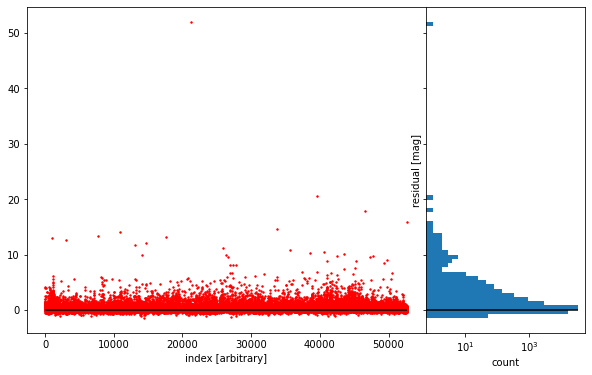

In [149]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, gridspec_kw={"width_ratios":[5,2]}, figsize=(10,6))
plt.subplots_adjust(wspace=0)

residuals = full_rr_lyrae_table["g_absorption"] - AG

ax1.scatter(np.arange(len(residuals)), residuals, s=2, color="red")
ax1.hlines(0, 0, len(residuals), color="black")
ax1.set_xlabel("index [arbitrary]")
#ax2.set_ylabel("residual [mag]")

_ = ax2.hist(residuals, bins=70, orientation="horizontal")
ax2.set_xlabel("count")
ax2.set_xscale("log")
ax2.hlines(0, 0, np.max(_[0]), color="black")
#ax2.set_ylabel("resudual [mag]")

plt.ylabel("residual [mag]")
#plt.ylim(-10, 20)

In [150]:
comparison = percent_difference(AG, full_rr_lyrae_table["g_absorption"])
print("min=",np.min(comparison), "\nmax=",np.max(comparison),
      "\nmean=", np.mean(comparison), "\nstd=",np.std(comparison))

min= -12121.243236231128 
max= 12322.67997234232 
mean= 0.51230890162546 
std= 88.76260025407417


# 1.28 

In [151]:
temp = np.asarray(AG)
np.sort(temp)[len(temp)-20:]

array([4.96520199, 4.97729097, 5.0223011 , 5.02923877, 5.04982843,
       5.05037162, 5.0555796 , 5.18551472, 5.23684379, 5.24544056,
       5.258594  , 5.26870677, 5.26991543, 5.32417165, 5.32740856,
       5.34298428, 5.3998802 , 6.01364184, 6.19227842, 6.69585865])

Text(0.5, 1.0, 'Calulated G band extinction of \n')

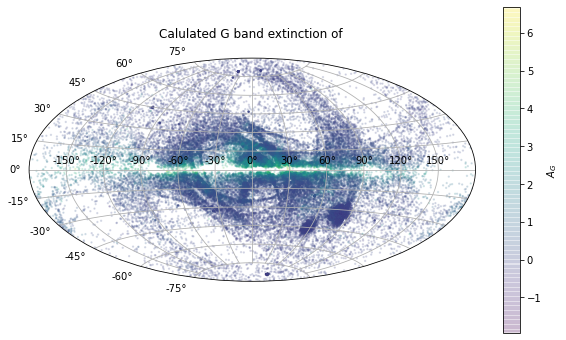

In [152]:
plt.figure(figsize=(10,6))
#norm = plt.Normalize()
#colors = plt.cm.viridis(AG)

gal = SkyCoord(full_rr_lyrae_table["ra"], full_rr_lyrae_table["dec"], frame="icrs", unit=u.deg).galactic

plt.subplot(111, projection="aitoff")
plt.grid(True)
plt.scatter(-gal.l.wrap_at("180d").radian, gal.b.radian, s=2, alpha=0.15, c=AG, cmap="viridis")
plt.colorbar(label=r"$A_G$")
plt.title("Calulated G band extinction of \n")

In [170]:
reduce_index = sigma_clip(AG, 3.5)
reduced_AG = AG[reduce_index]
reduced_table = full_rr_lyrae_table[reduce_index]

In [171]:
diff = len(full_rr_lyrae_table) - len(reduced_table)
print("I removed %s sources"%diff)

I removed 600 sources


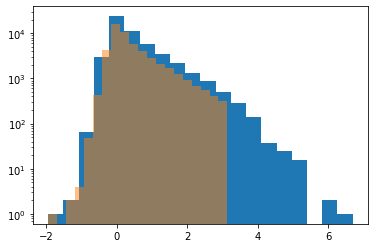

In [172]:
plt.figure()
_ = plt.hist(AG, bins=20)
__ = plt.hist(reduced_AG, bins=20, alpha=.5)
plt.yscale("log")

Text(0.5, 1.0, 'Calulated G band extinction of\nRR Lyrae stars\n')

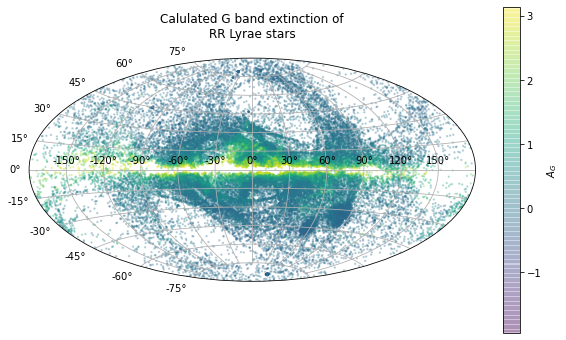

In [173]:
plt.figure(figsize=(10,6))
#norm = plt.Normalize()
#colors = plt.cm.viridis(AG)

gal = SkyCoord(reduced_table["ra"], reduced_table["dec"], frame="icrs", unit=u.deg).galactic

plt.subplot(111, projection="aitoff")
plt.grid(True)
plt.scatter(-gal.l.wrap_at("180d").radian, gal.b.radian, s=2, alpha=0.25, c=reduced_AG, cmap="viridis")
plt.colorbar(label=r"$A_G$")
plt.title("Calulated G band extinction of\nRR Lyrae stars\n")
#plt.savefig("cleaned_extinction_map.pdf")

Looking at the dust map above, we can see that there are a large number of sources along the galactic plane and along the path that gaia's field of view sweeps out on the sky. Due to the luminosity of RR Lyrae stars, we will see less stars when we are looking in a direction away from the center of the Milky Way because of how much further away RR Lyrae in other galaxies are. 

# 1.29 

Data selection and plotting based on [dustmaps documentation](https://dustmaps.readthedocs.io/en/latest/examples.html)

In [174]:
from __future__ import print_function
from dustmaps.sfd import SFDQuery

In [175]:
import dustmaps.sfd
dustmaps.sfd.fetch()

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


In [176]:
sfd = SFDQuery()
coords = SkyCoord(reduced_table["l"], reduced_table["b"],
                 unit="deg", frame="galactic")
Av_sfd = 2.742*sfd(coords)

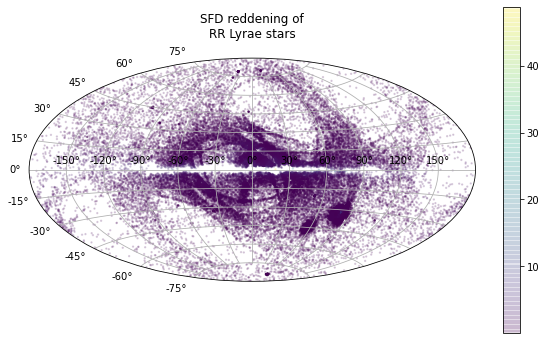

In [177]:
plt.figure(figsize=(10,6))
#norm = plt.Normalize()
colors = plt.cm.viridis(Av_sfd)

gal = SkyCoord(reduced_table["ra"], reduced_table["dec"], frame="icrs", unit=u.deg).galactic

plt.subplot(111, projection="aitoff")
plt.grid(True)
plt.scatter(-gal.l.wrap_at("180d").radian, gal.b.radian, s=2, alpha=0.15, c=Av_sfd, cmap="viridis")
#plt.colorbar(colors)
plt.title("SFD reddening of\nRR Lyrae stars\n")

plt.colorbar()

# 1.30

I do not expect my dust map to look exactly like the SFD plot, but there should be some similarities. Due to the SFD construction being based on the far-infrared emission of dust, it will have far more small structure detail than the reddening I calculated. The large scale structure of dust from the center of the Milky Way will be present in both my dust map and the SFD dust map.